# import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno
import os
from datetime import datetime, timedelta
import datetime as dt
import calendar
import time
from haversine import haversine #위경도 거리 계산
from functools import partial #데이터프레임에서 다중 컬럼을 이용하여 map or apply 사용을 위해 함수 조건 적용
from dateutil.relativedelta import relativedelta # sql add_month와 유사 역할
plt.style.use("seaborn-darkgrid")
plt.rc("font",family = "Malgun Gothic")
plt.rc("axes",unicode_minus = False)

warnings.filterwarnings(action = "ignore")
pd.options.display.max_rows=100
pd.options.display.max_columns = 100

# load files

In [2]:
next(os.walk("./data"))
# import os;os.listdir('./data')

('./data',
 ['.ipynb_checkpoints'],
 ['ddd.xlsx',
  'NATIONAL REPORT ON E-COMMERCE.pdf',
  'olist_closed_deals_dataset.csv',
  'olist_customers_dataset.csv',
  'olist_geolocation_dataset.csv',
  'olist_marketing_qualified_leads_dataset.csv',
  'olist_orders_dataset.csv',
  'olist_order_items_dataset.csv',
  'olist_order_payments_dataset.csv',
  'olist_order_reviews_dataset.csv',
  'olist_products_dataset.csv',
  'olist_sellers_dataset.csv',
  'product_category_name_translation.csv'])

In [3]:
product_category_name_translation = pd.read_csv("./data/product_category_name_translation.csv")
olist_products = pd.read_csv("./data/olist_products_dataset.csv")
olist_order_items = pd.read_csv("./data/olist_order_items_dataset.csv")
olist_sellers = pd.read_csv("./data/olist_sellers_dataset.csv")
olist_orders = pd.read_csv("./data/olist_orders_dataset.csv")
olist_customers = pd.read_csv("./data/olist_customers_dataset.csv")
olist_order_payments = pd.read_csv("./data/olist_order_payments_dataset.csv")
olist_order_reviews = pd.read_csv("./data/olist_order_reviews_dataset.csv")

olist_geolocation = pd.read_csv("./data/olist_geolocation_dataset.csv")
# olist_closed_deals = pd.read_csv("./data/olist_closed_deals_dataset.csv")
# olist_marketing_qualified_leads = pd.read_csv("./data/olist_marketing_qualified_leads_dataset.csv")

# 데이터셋별 전처리

## olist_products + product_category_name_translation
**포르투갈어로 되어 있는 상품명을 영문으로 변환**

In [4]:
olist_products_replace_cat_name = olist_products.copy()

#상품명 통일
olist_products_replace_cat_name.loc[olist_products_replace_cat_name.product_category_name.str.contains("^portateis")==True,"product_category_name"] = "portateis_casa_forno_e_cafe"
olist_products_replace_cat_name.loc[olist_products_replace_cat_name.product_category_name.str.contains("^pc")==True,"product_category_name"] = "pcs"

#상품명 영어로 변환
olist_products_eng = pd.merge(olist_products_replace_cat_name, product_category_name_translation, on = "product_category_name", how = "left")

## olist_order_items :  payement_value_cal 컬럼 생성
**olist_order_payments에 payment_value(상품가격 + 배송비)가 있으나,  
해당 컬럼 값이 문제가 없는지 확인하기 위한 용도로 직접 상품가격 + 배송비를 계산하여 컬럼으로 생성**

In [5]:
olist_order_items["sales"] = olist_order_items["price"]+olist_order_items["freight_value"]
olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,sales
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,72.19
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,259.83
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,216.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,218.04


## olist_order_items : order_id별 동일한 상품명 및 판매자인 중복 행 합치기
**한 구매 건수(order_id)에 동일한 상품이 여러 개의 관측치로 나눠져 있는 경우 하나로 합치고,
상품별 개수를 따로 지정**

In [6]:
olist_order_items[olist_order_items.order_id=="ca3625898fbd48669d50701aba51cd5f"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,sales
89007,ca3625898fbd48669d50701aba51cd5f,1,1065e0ebef073787a7bf691924c60eeb,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,309.0,1.84,310.84
89008,ca3625898fbd48669d50701aba51cd5f,2,0cf2faf9749f53924cea652a09d8e327,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,33.9,1.84,35.74
89009,ca3625898fbd48669d50701aba51cd5f,3,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,159.0,3.67,162.67
89010,ca3625898fbd48669d50701aba51cd5f,4,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,159.0,3.67,162.67
89011,ca3625898fbd48669d50701aba51cd5f,5,5dae498eff2d80057f56122235a36aff,888faa8bfb0b159c37de6d898b961c31,2018-08-17 02:25:07,95.9,0.15,96.05
89012,ca3625898fbd48669d50701aba51cd5f,6,4a5c3967bfd3629fe07ef4d0cc8c3818,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,109.9,0.15,110.05
89013,ca3625898fbd48669d50701aba51cd5f,7,678c229b41c0e497d35a25a8be1cc631,888faa8bfb0b159c37de6d898b961c31,2018-08-17 02:25:07,95.9,0.15,96.05
89014,ca3625898fbd48669d50701aba51cd5f,8,21b524c4c060169fa75ccf08c7da4627,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,63.7,0.15,63.85
89015,ca3625898fbd48669d50701aba51cd5f,9,309dd69eb83cea38c51709d62befe1a4,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,56.0,3.68,59.68
89016,ca3625898fbd48669d50701aba51cd5f,10,309dd69eb83cea38c51709d62befe1a4,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,56.0,3.68,59.68


In [7]:
olist_order_items_temp = olist_order_items.groupby(["order_id","product_id","seller_id","shipping_limit_date","price","freight_value"])\
.agg({"order_item_id" : "count", "sales" : "sum"}).reset_index().rename(columns = {"order_item_id" : "num"})
olist_order_items_temp[olist_order_items_temp.order_id=="ca3625898fbd48669d50701aba51cd5f"]

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,sales
80867,ca3625898fbd48669d50701aba51cd5f,0cf2faf9749f53924cea652a09d8e327,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,33.9,1.84,1,35.74
80868,ca3625898fbd48669d50701aba51cd5f,0de59eddc63167215c972b0d785ffa7b,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,159.0,3.67,2,325.34
80869,ca3625898fbd48669d50701aba51cd5f,1065e0ebef073787a7bf691924c60eeb,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,309.0,1.84,1,310.84
80870,ca3625898fbd48669d50701aba51cd5f,21b524c4c060169fa75ccf08c7da4627,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,63.7,0.15,1,63.85
80871,ca3625898fbd48669d50701aba51cd5f,309dd69eb83cea38c51709d62befe1a4,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,56.0,3.68,2,119.36
80872,ca3625898fbd48669d50701aba51cd5f,4a5c3967bfd3629fe07ef4d0cc8c3818,0b35c634521043bf4b47e21547b99ab5,2018-08-16 02:25:07,109.9,0.15,1,110.05
80873,ca3625898fbd48669d50701aba51cd5f,5dae498eff2d80057f56122235a36aff,888faa8bfb0b159c37de6d898b961c31,2018-08-17 02:25:07,95.9,0.15,1,96.05
80874,ca3625898fbd48669d50701aba51cd5f,678c229b41c0e497d35a25a8be1cc631,888faa8bfb0b159c37de6d898b961c31,2018-08-17 02:25:07,95.9,0.15,1,96.05


## olist_order_payments : order_id별 payment_value만 남기고 모두 삭제
**해당 데이터셋에선 payment_value와 order_id 컬럼만 사용할 예정이므로, order_id 기준으로 데이터 정제**

In [1146]:
olist_order_payments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [8]:
olist_order_payments_temp = olist_order_payments.groupby("order_id").payment_value.sum().reset_index().copy()
olist_order_payments_temp.head(1)

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19


## olist_order_reviews : 데이터 확인
**특정 구매 건(order_id)의 경우 review가 여러 개 달린 게 있는데, 이 부분은 전체 dataset을 merge 후  
구매 건마다 review가 2개 이상인 경우 제거**

In [9]:
olist_order_reviews.order_id.value_counts().reset_index().head(10)

,index,order_id
0,03c939fd7fd3b38f8485a0f95798f1f6,3
1,8e17072ec97ce29f0e1f111e598b0c85,3
2,c88b1d1b157a9999ce368f218a407141,3
3,df56136b8031ecd28e200bb18e6ddb2e,3
4,1c308eca3f339414a92e518e2a2e5ee9,2
5,6f78a74ebcd33afa2bccc0c0a82ff04a,2
6,b34fa044fec24bf9206a7b2b022dd92c,2
7,f86e20fe6ce750c00d7ed08e8c67384f,2
8,ca263afd88a8a1200605adbd4b63cd7d,2
9,bb2481cfc7467d4d8ee14699270dd7e8,2


In [10]:
olist_order_reviews[olist_order_reviews.order_id=="03c939fd7fd3b38f8485a0f95798f1f6"]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
8329,b04ed893318da5b863e878cd3d0511df,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,Um ponto negativo que achei foi a cobrança de ...,2018-03-20 00:00:00,2018-03-21 02:28:23
51931,f4bb9d6dd4fb6dcc2298f0e7b17b8e1e,03c939fd7fd3b38f8485a0f95798f1f6,4,NaN,NaN,2018-03-29 00:00:00,2018-03-30 00:29:09
70005,405eb2ea45e1dbe2662541ae5b47e2aa,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,Seria ótimo se tivesem entregue os 3 (três) pe...,2018-03-06 00:00:00,2018-03-06 19:50:32


In [11]:
olist_orders[olist_orders.order_id=="03c939fd7fd3b38f8485a0f95798f1f6"]
# olist_order_items[olist_order_items.order_id=="03c939fd7fd3b38f8485a0f95798f1f6"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
12362,03c939fd7fd3b38f8485a0f95798f1f6,2a35ad9f439dfc62d35a0202e71d6c66,delivered,2018-02-25 21:01:08,2018-02-26 09:35:46,2018-02-26 22:46:40,2018-03-19 21:48:52,2018-04-02 00:00:00


## olist_order_reviews : comment text mining(진행 중)

import requests
def translate_by_kakao(query, src, target):
    url = 'https://translate.kakao.com/translator/translate.json'
    header = {"Referer" : "https://translate.kakao.com/"}
    data = {"queryLanguage" : src,
            "resultLanguage" : target,
            "q" : query}
    
    response = requests.post(url,headers = header, data = data)
    results = response.json()["result"]["output"]
    return results

query = olist_order_reviews_copy.review_comment_message[3]
#query
translate_by_kakao(query, "pt", "ko")

#for문
url = 'https://translate.kakao.com/translator/translate.json'
header = {"Referer" : "https://translate.kakao.com/"}
olist_order_reviews_copy["review_comment_msg_ko"] = np.nan
olist_order_reviews_copy["review_comment_msg_en"] = np.nan

for i in range(len(olist_order_reviews)):
    print(f"[{round((i+1)/len(olist_order_reviews),2)}]{i+1}행 진행 중")
    if type(olist_order_reviews_copy.iloc[i].review_comment_message)==str:
        query = olist_order_reviews_copy.iloc[i].review_comment_message

        olist_order_reviews_copy["review_comment_msg_en"][i] = translate_by_kakao(query, "pt", "en")
        olist_order_reviews_copy["review_comment_msg_ko"][i] = translate_by_kakao(query, "pt", "ko")
        sleep_time = np.random.random_integers(low = 0, high = 25)/10
        time.sleep(sleep_time)

#map함수 사용
#사용은 가능하나 api호출이 단기간에 이뤄져서 ddos로 의심될 수 있으므로 for문으로 sleep 지정해서 하는 것으로 변경
olist_order_reviews["review_comment_msg_ko"] = olist_order_reviews.review_comment_message.map(lambda x : translate_by_kakao(x, "pt","ko"))
olist_order_reviews["review_comment_msg_en"] = olist_order_reviews.review_comment_message.map(lambda x : translate_by_kakao(x, "pt","en"))

olist_order_reviews.head(2)

## olist_geolocation - zipcode, city, state로 groupby하여 lat,lng의 중간 위치 구하기
**geolocation_zip_code별로 하나의 위경도 값만 남기기 위해 zip_code 기준으로 groupby**

In [1151]:
olist_geolocation.sort_values("geolocation_zip_code_prefix")

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1246,1001,-23.549292,-46.633559,sao paulo,SP
429,1001,-23.550498,-46.634338,sao paulo,SP
1182,1001,-23.549779,-46.633957,sao paulo,SP
1435,1001,-23.549292,-46.633559,sao paulo,SP
326,1001,-23.551427,-46.634074,sao paulo,SP
...,...,...,...,...,...
1000026,99980,-28.388679,-51.848863,david canabarro,RS
999950,99980,-28.388400,-51.845225,david canabarro,RS
1000002,99980,-28.388342,-51.845194,david canabarro,RS
999864,99990,-28.329472,-51.769109,muliterno,RS


In [1152]:
# olist_geolocation["geolocation_zip_code_prefix"]=olist_geolocation.geolocation_zip_code_prefix.astype(str)
olist_geolocation_mean = olist_geolocation.groupby(["geolocation_zip_code_prefix","geolocation_state"])\
[["geolocation_lat","geolocation_lng"]].mean().reset_index()
olist_geolocation_mean.head(2)

,geolocation_zip_code_prefix,geolocation_state,geolocation_lat,geolocation_lng
0,1001,SP,-23.550190,-46.634024
1,1002,SP,-23.548146,-46.634979


## column_list, olist_order_items : 데이터 타입 변경(일자컬럼 : object => datetime)

In [1153]:
# olist_orders
column_list= ["order_purchase_timestamp","order_approved_at","order_delivered_carrier_date",
               "order_delivered_customer_date","order_estimated_delivery_date"]
olist_orders[column_list] = olist_orders[column_list].apply(pd.to_datetime)
# olist_order_items
olist_order_items["shipping_limit_date"] = olist_order_items.shipping_limit_date.apply(pd.to_datetime)


# merge all

**olist_products_eng = olist_products_replace_cat_name + product_category_name_translation**  
**temp0 = olist_order_items + olist_products_eng**  
**olist_sellers_geo = olist_sellers + olist_geolocation**  
**temp1 = olist_sellers + olist_order_items**  
**temp2 = temp1 + olist_orders_geo**  
**olist_customers_geo = olist_customer + olist_geolocation**  
**temp3 = temp2 + olist_customers_geo**  
**temp4 = temp3 + olist_order_payments**  
**temp5 = temp4 + olist_order_reviews_mean**  

In [1154]:
olist_sellers_geo = pd.merge(olist_sellers,olist_geolocation_mean,left_on = ["seller_zip_code_prefix"],
        right_on = ["geolocation_zip_code_prefix"],how = "left")

In [1155]:
olist_customers_geo = pd.merge(olist_customers,olist_geolocation_mean,left_on = ["customer_zip_code_prefix"],
        right_on = ["geolocation_zip_code_prefix"],how = "left")

In [1156]:
temp0 = pd.merge(olist_order_items_temp,olist_products_eng,on="product_id",how="outer")
# temp1 = pd.merge(temp0,olist_sellers,on="seller_id",how="outer")
temp1 = pd.merge(temp0,olist_sellers_geo,on="seller_id",how="outer")
temp2 = pd.merge(temp1,olist_orders,on = "order_id",how = "outer")
# temp3 = pd.merge(temp2,olist_customers,on = "customer_id",how = "outer")
temp3 = pd.merge(temp2,olist_customers_geo,on = "customer_id",how = "outer")
temp4 = pd.merge(temp3,olist_order_payments,on = "order_id",how = "outer")
temp5 = pd.merge(temp4,olist_order_reviews,on = "order_id",how = "outer")
df = temp5.copy()

# 결합 후 전처리

## 년도~시간대 컬럼 생성

In [1157]:
def generate_from_year_to_hour(dataframe, column):
    df = dataframe.copy()
    df["year_month"] = df[column].map(lambda x : dt.datetime(x.year,x.month,1)).dt.date
    df["year"] = df[column].dt.year
    df["month"] = df[column].dt.month
    df["week"] = df[column].dt.week
    df["day"] = df[column].dt.day
    df["weekday"] = df[column].dt.weekday
    return df

In [1158]:
df = generate_from_year_to_hour(df,"order_purchase_timestamp")

#임시로 요일 및 시간대 컬럼 생성
df["weekday_eng"] = df.order_purchase_timestamp.dt.weekday.map(lambda x : calendar.day_name[x][:3])
df["hour"] = df.order_purchase_timestamp.dt.hour
df.head(3)

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,sales,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_x,geolocation_state_x,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix_y,geolocation_state_y,geolocation_lat_y,geolocation_lng_y,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,year_month,year,month,week,day,weekday,weekday_eng,hour
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,1.0,72.19,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,27277.0,volta redonda,SP,27277.0,RJ,-22.496953,-44.127492,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,28013.0,RJ,-21.762775,-41.309633,72.19,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,2017-09-01,2017,9,37,13,2,Wed,8
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,1.0,73.86,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,27277.0,volta redonda,SP,27277.0,RJ,-22.496953,-44.127492,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,75800.0,GO,-17.884337,-51.716990,73.86,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 00:00:00,2017-07-17 12:50:07,2017-06-01,2017,6,26,28,2,Wed,11
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,1.0,83.23,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,27277.0,volta redonda,SP,27277.0,RJ,-22.496953,-44.127492,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,30720.0,MG,-19.914323,-43.975703,83.23,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05 00:00:00,2018-06-06 21:41:12,2018-05-01,2018,5,20,18,4,Fri,10


In [1159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103891 entries, 0 to 103890
Data columns (total 54 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       103891 non-null  object        
 1   product_id                     103112 non-null  object        
 2   seller_id                      103112 non-null  object        
 3   shipping_limit_date            103112 non-null  object        
 4   price                          103112 non-null  float64       
 5   freight_value                  103112 non-null  float64       
 6   num                            103112 non-null  float64       
 7   sales                          103112 non-null  float64       
 8   product_category_name          101642 non-null  object        
 9   product_name_lenght            101642 non-null  float64       
 10  product_description_lenght     101642 non-null  float64       
 11  

## 이상치 처리

### order_id별 review 개수가 2개 이상인 경우 제거
**특정 order_id에서 review 개수가 2개 이상인데, 이 경우 단순히 점수를 올리기 위해서 발생한 경우도 있고,
실제로 판매자가 특정 상황이 발생하여 대처 전후에 대해 review를 한 경우가 있으나,
모든 경우를 고려하기가 불가하여 해당 order_id 제거**

In [1160]:
OrderId_ReviewId = olist_order_reviews.groupby("order_id").review_id.agg("nunique").reset_index()
order_id_list = OrderId_ReviewId[OrderId_ReviewId.review_id>1].order_id.tolist()
df = df[~df.order_id.isin(order_id_list)]
df.review_score.unique()

array([5, 4, 1, 3, 2], dtype=int64)

### order_id별 seller가 2명 이상인 경우 제거
**각 order_id별로 review_score가 정해지는데, seller가 두명 이상인 경우 사항으로 점수가 기입됐는지 확인이 불가**

In [1161]:
OrderID_SellerID = df.groupby("order_id").seller_id.nunique().reset_index()
order_id_list = OrderID_SellerID[OrderID_SellerID.seller_id>1].order_id.tolist()
df = df[~df.order_id.isin(order_id_list)]


### 구매 시점이 결제 승인, 상품 준비, 배송완료일, 배송완료 예정일이 늦은 판매건 제거

In [1162]:
df[df.order_purchase_timestamp > df.order_delivered_carrier_date][["order_purchase_timestamp","order_approved_at","order_delivered_customer_date","order_delivered_carrier_date","order_estimated_delivery_date"]]

,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_delivered_carrier_date,order_estimated_delivery_date
3555,2018-08-03 14:09:07,2018-08-03 14:43:51,2018-08-08 18:51:39,2018-08-03 13:55:00,2018-08-21
3685,2018-08-15 15:48:50,2018-08-15 16:05:12,2018-08-22 22:34:27,2018-08-15 14:16:00,2018-09-04
6239,2018-08-23 15:50:07,2018-08-23 16:05:38,2018-08-27 19:11:17,2018-08-23 15:31:00,2018-09-06
7415,2018-06-26 14:57:28,2018-06-26 15:16:21,2018-06-28 21:48:51,2018-06-26 14:50:00,2018-08-01
7609,2018-05-23 15:50:05,2018-05-23 16:16:01,2018-06-07 19:31:51,2018-05-23 14:51:00,2018-07-02
...,...,...,...,...,...
100952,2018-07-16 18:40:53,2018-07-16 18:50:22,2018-07-23 20:04:45,2018-01-26 13:35:00,2018-08-07
101860,2018-05-16 15:02:31,2018-05-16 15:19:36,2018-05-21 16:53:46,2018-05-16 14:29:00,2018-06-05
102314,2018-08-10 16:05:40,2018-08-10 16:15:17,2018-08-15 19:04:02,2018-08-10 15:18:00,2018-08-27
102325,2018-06-20 14:02:25,2018-06-20 14:18:42,2018-06-21 15:04:21,2018-06-20 13:32:00,2018-07-05


In [1163]:
print(f" order_purchase_timestamp > order_approved_at : {len(df[df.order_purchase_timestamp > df.order_approved_at])}")
print(f" order_purchase_timestamp > order_delivered_customer_date : {len(df[df.order_purchase_timestamp > df.order_delivered_customer_date])}")
print(f" order_purchase_timestamp > order_delivered_carrier_date : {len(df[df.order_purchase_timestamp > df.order_delivered_carrier_date])}")
print(f" order_purchase_timestamp > order_estimated_delivery_date : {len(df[df.order_purchase_timestamp > df.order_estimated_delivery_date])}")

 order_purchase_timestamp > order_approved_at : 0
 order_purchase_timestamp > order_delivered_customer_date : 0
 order_purchase_timestamp > order_delivered_carrier_date : 165
 order_purchase_timestamp > order_estimated_delivery_date : 0


In [1164]:
df = df[df.order_purchase_timestamp <= df.order_delivered_carrier_date]

## 결측치 처리

In [1165]:
null_sum = df.isnull().sum().to_frame().rename(columns = {0 : "null(nb)"})
null_mean = (df.isnull().mean()*100).round(2).to_frame().rename(columns = {0 : "null(%)"})
print(df.shape)
null_list = pd.merge(null_sum,null_mean,left_index = True, right_index = True, how = "outer")
null_list[null_list["null(nb)"]>0].T

(97969, 54)


,product_id,seller_id,shipping_limit_date,price,freight_value,num,sales,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_x,geolocation_state_x,geolocation_lat_x,geolocation_lng_x,order_approved_at,order_delivered_customer_date,geolocation_zip_code_prefix_y,geolocation_state_y,geolocation_lat_y,geolocation_lng_y,payment_value,review_comment_title,review_comment_message
null(nb),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1387.00,1387.00,1387.00,1387.00,17.00,17.00,17.00,17.00,1387.00,1.0,1.0,1.0,215.00,215.00,215.00,215.00,14.00,1187.00,266.00,266.00,266.00,266.00,1.0,86565.00,57572.00
null(%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.42,1.42,1.42,1.42,0.02,0.02,0.02,0.02,1.42,0.0,0.0,0.0,0.22,0.22,0.22,0.22,0.01,1.21,0.27,0.27,0.27,0.27,0.0,88.36,58.77


### product_category_name이 결측치인 관측치 제거

In [1166]:
df_temp = df[df.product_category_name.notnull()==True].copy()

null_sum = df_temp.isnull().sum().to_frame().rename(columns = {0 : "null(nb)"})
null_mean = (df_temp.isnull().mean()*100).round(2).to_frame().rename(columns = {0 : "null(%)"})
print(df_temp.shape)
null_list = pd.merge(null_sum,null_mean,left_index = True, right_index = True, how = "outer")
null_list[null_list["null(nb)"]>0].T

(96582, 54)


,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_zip_code_prefix_x,geolocation_state_x,geolocation_lat_x,geolocation_lng_x,order_approved_at,order_delivered_customer_date,geolocation_zip_code_prefix_y,geolocation_state_y,geolocation_lat_y,geolocation_lng_y,payment_value,review_comment_title,review_comment_message
null(nb),1.0,1.0,1.0,1.0,213.00,213.00,213.00,213.00,13.00,1161.0,260.00,260.00,260.00,260.00,1.0,85239.00,56779.00
null(%),0.0,0.0,0.0,0.0,0.22,0.22,0.22,0.22,0.01,1.2,0.27,0.27,0.27,0.27,0.0,88.26,58.79


### order_delivered_customer_date 결측치 확인
***
- 배송이 완료되지 않았거나, 배송 취소, 배송 불가로 인한 배송완료일자 결측사항 발생**
- 관측치를 제거하진 말고, 추후에 Nan일 경우 제외하고 mean 하는 것으로 협의
- 단 delivered인데 결측치가 있는 관측치는 제거

total : 1161


shipped      1088
canceled       66
delivered       7
Name: order_status, dtype: int64

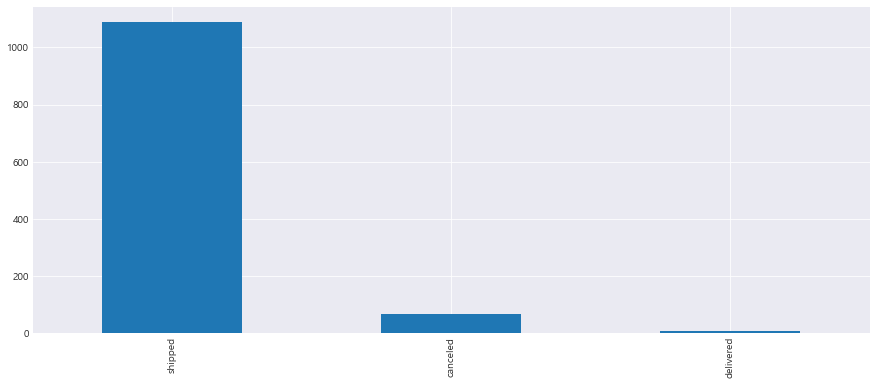

In [1167]:
df_temp[df_temp.order_delivered_customer_date.isnull()==True].order_status.value_counts().plot.bar(figsize = (15,6))
print(f"total : {df_temp[df_temp.order_delivered_customer_date.isnull()==True].order_status.value_counts().sum()}")
df_temp[df_temp.order_delivered_customer_date.isnull()==True].order_status.value_counts()

**order_status == delivered & order_delivered_carrier_date or order_delivered_customer_date가 없는 관측치 제거**

In [1168]:
df_temp = df_temp[(df_temp.order_status!="delivered") | (df_temp.order_delivered_carrier_date.notnull()==True)]

In [1169]:
df_temp = df_temp[(df.order_status!="delivered") | (df.order_delivered_customer_date.notnull()==True)]

In [1170]:
df_temp.isnull().sum().sort_values(ascending = False)

review_comment_title             85236
review_comment_message           56777
order_delivered_customer_date     1154
geolocation_zip_code_prefix_y      260
geolocation_state_y                260
geolocation_lat_y                  260
geolocation_lng_y                  260
geolocation_lng_x                  213
geolocation_lat_x                  213
geolocation_state_x                213
geolocation_zip_code_prefix_x      213
order_approved_at                   13
product_height_cm                    1
payment_value                        1
product_width_cm                     1
product_length_cm                    1
product_weight_g                     1
customer_zip_code_prefix             0
review_score                         0
review_id                            0
review_creation_date                 0
review_answer_timestamp              0
year_month                           0
year                                 0
month                                0
week                     

### geolocation_zip_code_prefix
***
- zip_code가 없는 고객과 판매자의 관측치는 제거하기로 함

In [1171]:
df_temp = df_temp[(df_temp.geolocation_zip_code_prefix_x.notnull()) & (df_temp.geolocation_zip_code_prefix_y.notnull())]
df_temp.isnull().sum().sort_values(ascending = False)

review_comment_title             84819
review_comment_message           56488
order_delivered_customer_date     1148
order_approved_at                   13
payment_value                        1
product_width_cm                     1
product_length_cm                    1
product_weight_g                     1
product_height_cm                    1
review_answer_timestamp              0
review_creation_date                 0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
geolocation_zip_code_prefix_y        0
geolocation_state_y                  0
geolocation_lat_y                    0
geolocation_lng_y                    0
weekday_eng                          0
review_id                            0
review_score                         0
weekday                              0
day                                  0
week                                 0
month                    

### order_approved_at 결측치 확인 => 불필요 (컬럼 삭제)
***
- 배송은 완료됐으나, order_approved_at 데이터 기입 누락 사항으로 확인
- order_approved_at 날짜가 불필요할 경우 해당 컬럼 삭제

In [1172]:
df_temp[df_temp.order_approved_at.isnull()==True]

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,sales,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_x,geolocation_state_x,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix_y,geolocation_state_y,geolocation_lat_y,geolocation_lng_y,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,year_month,year,month,week,day,weekday,weekday_eng,hour
15393,12a95a3c06dbaec84bcfb0e2da5d228a,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-21 12:05:55,79.99,15.77,1.0,95.76,cool_stuff,54.0,1012.0,1.0,1200.0,42.0,25.0,15.0,cool_stuff,3426.0,sao paulo,SP,3426.0,SP,-23.552336,-46.536869,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,c8822fce1d0bfa7ddf0da24fff947172,27945,macae,RJ,27945.0,RJ,-22.372457,-41.794318,95.76,4e44dd381f3c4f7afddacf8b9aa0c47a,5,NaN,NaN,2017-03-03 00:00:00,2017-03-04 00:06:38,2017-02-01,2017,2,7,17,4,Fri,13
15401,2babbb4b15e6d2dfe95e2de765c97bce,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 16:15:03,79.99,26.82,1.0,106.81,cool_stuff,54.0,1012.0,1.0,1200.0,42.0,25.0,15.0,cool_stuff,3426.0,sao paulo,SP,3426.0,SP,-23.552336,-46.536869,74bebaf46603f9340e3b50c6b086f992,delivered,2017-02-18 17:15:03,NaT,2017-02-22 11:23:11,2017-03-03 18:43:43,2017-03-31,f79be7c08dd24b72d34634f1b89333a4,65110,sao jose de ribamar,MA,65110.0,MA,-2.551848,-44.139002,106.81,da0dc17903d0f8aa4b041dcd7f2dacff,4,NaN,"Além do produto chegar antes do previsto, a qu...",2017-03-04 00:00:00,2017-03-06 23:20:42,2017-02-01,2017,2,7,18,5,Sat,17
15432,5cf925b116421afa85ee25e99b4c34fb,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 15:48:35,79.99,26.82,1.0,106.81,cool_stuff,54.0,1012.0,1.0,1200.0,42.0,25.0,15.0,cool_stuff,3426.0,sao paulo,SP,3426.0,SP,-23.552336,-46.536869,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31,7e1a5ca61b572d76b64b6688b9f96473,62700,caninde,CE,62700.0,CE,-4.355929,-39.314376,106.81,4930703ae4fccd4d2d3b44cf63a9e632,5,NaN,NaN,2017-03-10 00:00:00,2017-03-13 00:18:46,2017-02-01,2017,2,7,18,5,Sat,16
30646,88083e8f64d95b932164187484d90212,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.00,14.52,2.0,127.04,telefonia,61.0,440.0,1.0,250.0,18.0,3.0,28.0,telephony,11010.0,santos,SP,11010.0,SP,-23.933573,-46.329625,f67cd1a215aae2a1074638bbd35a223a,delivered,2017-02-18 22:49:19,NaT,2017-02-22 11:31:06,2017-03-02 12:06:06,2017-03-21,bc1896dc77f49e6dec880445a9b443a3,21020,rio de janeiro,RJ,21020.0,RJ,-22.835828,-43.276144,127.04,331c2fea3f2c1512a9ca1889436a6904,4,NaN,O serviço do site dessa vez foi otimo. \r\nEm ...,2017-03-03 00:00:00,2017-03-04 03:45:57,2017-02-01,2017,2,7,18,5,Sat,22
38577,51eb2eebd5d76a24625b31c33dd41449,7868a64aa111bbb4f41f8e1146c0becb,cca3071e3e9bb7d12640c9fbe2301306,2017-02-28 14:52:27,59.90,17.16,1.0,77.06,moveis_decoracao,59.0,438.0,1.0,1200.0,30.0,5.0,20.0,furniture_decor,14940.0,ibitinga,SP,14940.0,SP,-21.757321,-48.829744,07a2a7e0f63fd8cb757ed77d4245623c,delivered,2017-02-18 15:52:27,NaT,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29,79af1bbf230a2630487975aa5d7d6220,37660,paraisopolis,MG,37660.0,MG,-22.551534,-45.778573,77.06,6352329f467fe888f25b35e48b11b97e,5,NaN,NaN,2017-03-09 00:00:00,2017-03-09 08:14:03,2017-02-01,2017,2,7,18,5,Sat,15
38745,7002a78c79c519ac54022d4f8a65e6e8,c3b271f47e73d0c9ccf1b43b7606c70

### product_width & length & height_cm결측치 확인 => 불필요(컬럼 삭제)
***
- 하기 상품 정보 누락 확인
- 상품 규격이 불필요할 경우 해당 컬럼 삭제

In [1173]:
df_temp[df_temp.product_width_cm.isnull()==True]

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,sales,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_x,geolocation_state_x,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix_y,geolocation_state_y,geolocation_lat_y,geolocation_lng_y,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,year_month,year,month,week,day,weekday,weekday_eng,hour
85709,85f8ad45e067abd694b627859fa57453,09ff539a621711667c43eba6a3bd8466,8b8cfc8305aa441e4239358c9f6f2485,2017-02-03 21:40:02,1934.0,27.0,1.0,1961.0,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN,baby,86020.0,londrina,PR,86020.0,PR,-23.312601,-51.16718,1d088dea8732788ec35dd4ee6dd76112,delivered,2017-01-29 21:40:02,2017-01-30 22:32:20,2017-02-02 05:04:58,2017-02-07 10:46:00,2017-03-08,69b2b29382af03e03e486ad307a76000,90160,porto alegre,RS,90160.0,RS,-30.051007,-51.217957,1961.0,125af5098b160c059cd60bafcc1f6ad1,5,NaN,NaN,2017-02-08 00:00:00,2017-02-09 10:09:24,2017-01-01,2017,1,4,29,6,Sun,21


In [1174]:
df_temp[df_temp.product_id=="09ff539a621711667c43eba6a3bd8466"]

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,sales,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_x,geolocation_state_x,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix_y,geolocation_state_y,geolocation_lat_y,geolocation_lng_y,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,year_month,year,month,week,day,weekday,weekday_eng,hour
85709,85f8ad45e067abd694b627859fa57453,09ff539a621711667c43eba6a3bd8466,8b8cfc8305aa441e4239358c9f6f2485,2017-02-03 21:40:02,1934.0,27.0,1.0,1961.0,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN,baby,86020.0,londrina,PR,86020.0,PR,-23.312601,-51.16718,1d088dea8732788ec35dd4ee6dd76112,delivered,2017-01-29 21:40:02,2017-01-30 22:32:20,2017-02-02 05:04:58,2017-02-07 10:46:00,2017-03-08,69b2b29382af03e03e486ad307a76000,90160,porto alegre,RS,90160.0,RS,-30.051007,-51.217957,1961.0,125af5098b160c059cd60bafcc1f6ad1,5,NaN,NaN,2017-02-08 00:00:00,2017-02-09 10:09:24,2017-01-01,2017,1,4,29,6,Sun,21


### payment_value 결측치 확인 => sales로 대체
***
- payment_value 값 자체가 오계산된 것을 확인하여 sales로 대체
- 또한, 이후에 order_id, seller_id,year_month 등으로 groupby 예정이므로, order_id별 총액이 기입된 payment_value를 삭제

In [1175]:
tmp_items = olist_order_items.groupby("order_id").sales.sum().reset_index()
tmp_items

,order_id,sales
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,343.40
98662,fffcd46ef2263f404302a634eb57f7eb,386.53
98663,fffce4705a9662cd70adb13d4a31832d,116.85
98664,fffe18544ffabc95dfada21779c9644f,64.71


In [1176]:
tmp = pd.merge(olist_order_payments,tmp_items,on="order_id")
tmp[abs(tmp.payment_value-tmp.sales)>0.1]

,order_id,payment_value,sales
165,00789ce015e7e5791c7914f32bb4fad4,190.81,168.83
525,016726239765c18f66826453f39c64e3,265.77,235.13
724,01e51b7c3025655646143d09b911e1d7,35.02,33.10
965,028aa7c930356788f861ed1b7f984819,62.94,57.53
1123,02f4dd90ba0feb8ec394cac05862d2b5,141.65,130.96
...,...,...,...
96560,fa87437f971fce498b2184cd2401e23e,66.93,63.27
96713,faf132fb35b3b3b533a67efbd6e7c02d,130.01,115.02
97100,fbf352b18a26c6a86a53cca922facd25,160.80,151.54
97605,fd33085945f15975375cd8ec85440511,212.82,234.62


In [1177]:
olist_order_items[olist_order_items.order_id=="00789ce015e7e5791c7914f32bb4fad4"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,sales
185,00789ce015e7e5791c7914f32bb4fad4,1,f9d774a1820f792952eea079a40a7c6b,2709af9587499e95e803a6498a5a56e9,2017-07-04 23:43:34,154.0,14.83,168.83


In [1178]:
df[abs(df.payment_value-df.sales)>0.1][["payment_value","sales","price","freight_value"]]

,payment_value,sales,price,freight_value
7,153.75,77.02,58.90,18.12
8,153.75,76.73,58.90,17.83
17,167.51,83.89,55.90,27.99
18,167.51,83.62,55.90,27.72
43,130.01,61.78,48.90,12.88
...,...,...,...,...
102894,125.74,108.86,89.99,18.87
102935,277.68,138.84,119.90,18.94
102936,277.68,138.84,119.90,18.94
103033,675.75,535.00,520.00,15.00


### 년분기별 판매 건수 확인 => 데이터셋 17.1~18.8로 축소
- 16.9, 16.12 매출건수가 매우 적으므로 해당 기간의 데이터를 분석하기엔 부적절하다고 판단됨

In [1179]:
df_temp.groupby("year_month").order_id.count()

year_month
2016-09-01       3
2016-10-01     278
2016-12-01       1
2017-01-01     777
2017-02-01    1643
2017-03-01    2589
2017-04-01    2309
2017-05-01    3536
2017-06-01    3137
2017-07-01    3851
2017-08-01    4152
2017-09-01    4138
2017-10-01    4455
2017-11-01    7291
2017-12-01    5458
2018-01-01    6990
2018-02-01    6495
2018-03-01    6983
2018-04-01    6794
2018-05-01    6732
2018-06-01    6057
2018-07-01    6118
2018-08-01    6315
2018-09-01       1
Name: order_id, dtype: int64

In [1180]:
start_date = dt.date(2017,1,1)
end_date = dt.date(2018,9,1)
print(f"16.9~18.9 : {df_temp.shape}")
df_temp = df_temp[(df_temp.order_purchase_timestamp.dt.date >= start_date) &
                  (df_temp.order_purchase_timestamp.dt.date < end_date)].reset_index()
print(f"17.1~18.8 : {df_temp.shape}")

16.9~18.9 : (96103, 54)
17.1~18.8 : (95820, 55)


# Feature Eng

## 배송 속도, 기간, 배송 상품 준비 기간 컬럼 생성

In [1181]:
df_temp.order_status.unique()

array(['delivered', 'shipped', 'canceled'], dtype=object)

In [1182]:
### 배송 속도(완료일 대비 예정일)
df_temp["delivery_delay"] = (df_temp.order_delivered_customer_date -  df_temp.order_estimated_delivery_date).dt.days

### 배송 기간(구매~배송완료)
df_temp["delivery_periods"] = (df_temp.order_delivered_customer_date -  df_temp.order_purchase_timestamp).dt.days

### 배송 준비 기간(후보 )
df_temp["delivery_preparation"] = (df_temp.order_delivered_carrier_date -  df_temp.order_purchase_timestamp).dt.days

### order_status != delivered인 관측치 periods 컬럼 결측치 대체
- delivery_delay
- delivery_periods
- delivery_preparation

order_status가 processing, shipped, invoiced, approved인 경우  
배송이 완료되지 않아 배송완료 시점 등의 데이터가 없음  
이런 데이터는 현재 진행 중이라 판단하여, 데이터의 최종 시점인 18.8.31 기준으로 기간으로 대체

In [1183]:
# 배송기간 분포 확인
delivery_time = df_temp[df_temp.delivery_periods.notnull()].delivery_periods.tolist()

# 2018.8.31 기준으로 구매 시점부터 소요된 시간을 계산
last_date = dt.date(2018,8,31)

In [1184]:
#배송 기간에 대한 P-Value 계산
#order_status = delivered의 경우 배송 완료일자 기준
#order_status = not delivered인 경우 last_date 기준
timestamp, status, delivery_periods = df_temp["order_purchase_timestamp"], df_temp["order_status"], df_temp["delivery_periods"]
diff_times = []
for i in range(len(timestamp)):
    timestamp_list, status_list, delivery_periods_list = timestamp[i], status[i], delivery_periods[i]

    if status_list == "delivered":
        diff_time = delivery_periods_list
        diff_times.append(diff_time)
    else : 
        diff_time = (last_date - timestamp_list.date()).days
        diff_times.append(diff_time)
df_temp["diff_time"] = diff_times

In [1185]:
def reset_periods_except_delivered(df, status_col, delay_col, period_col, preparation_cal, diff_times):
    status_list, delay_list, period_list, preparation_list ,diff_time_list = \
    df[status_col], df[delay_col], df[period_col], df[preparation_cal], df[diff_times]
    
    if (status_list =="approved") | (status_list =="processing") | (status_list =="invoiced"):
        delay_list = diff_time_list
        period_list = diff_time_list
        preparation_list = diff_time_list
    elif status_list=="shipped":
        delay_list = diff_time_list
        period_list = diff_time_list
    
    df[delay_col] = delay_list
    df[period_col] = period_list
    df[preparation_cal] = preparation_list

    return df

In [1186]:
reset_periods_except_delivered_partial = partial(reset_periods_except_delivered,
                                                status_col = "order_status",
                                                delay_col = "delivery_delay",
                                                period_col = "delivery_periods",
                                                preparation_cal = "delivery_preparation",
                                                diff_times = "diff_time")
df_temp = pd.DataFrame(df_temp.apply(lambda x : reset_periods_except_delivered_partial(x),axis = 1))

In [1187]:
df_temp[df_temp.order_status=="canceled"].isnull().sum()

index                             0
order_id                          0
product_id                        0
seller_id                         0
shipping_limit_date               0
price                             0
freight_value                     0
num                               0
sales                             0
product_category_name             0
product_name_lenght               0
product_description_lenght        0
product_photos_qty                0
product_weight_g                  0
product_length_cm                 0
product_height_cm                 0
product_width_cm                  0
product_category_name_english     0
seller_zip_code_prefix            0
seller_city                       0
seller_state                      0
geolocation_zip_code_prefix_x     0
geolocation_state_x               0
geolocation_lat_x                 0
geolocation_lng_x                 0
customer_id                       0
order_status                      0
order_purchase_timestamp    

In [1188]:
df_temp[df_temp.delivery_delay.isnull()].order_status.unique()

array(['canceled'], dtype=object)

## 특이 건수 비율 컬럼 생성
- delivered를 제외하고 현재 배송 소요 기간이 전체 배송완료 건수의 분포에서 편측 신뢰구간 95%를 벗어나는 경우 특이건수로 판단
- delivered의 경우도 배송 소요 기간을 확인하여 신뢰구간을 벗어나면 특이건수로 판단

### delivery_time 신뢰구간으로 판단

In [1189]:
# 신뢰구간으로 특이 건수 판단
delivery_time_std = np.std(delivery_time)
delivery_time_mean = np.mean(delivery_time)

df_temp["P_val_periods"] = (diff_times - delivery_time_mean) / delivery_time_std

In [1190]:
#p_value가 편측 신뢰구간 95%(Z = 1.645) 이상인 경우 error, 아니면 non-error
df_temp["error_rate_based_on_CD"] = df_temp.P_val_periods.map(lambda x : 1 if x > 1.645 else 0)
#Confidence interval

# #order_status가 canceled or unavailable일 경우도 error로 적용
# def reset_order_status_new(df, origin, new):
#     origin, new = df[origin], df[new]
#     if (origin == "canceled") or (origin == "unavailable"):
#         new = 1
#     else :
#         new = new
#     return new

# reset_order_status_new_partial = partial(reset_order_status_new, origin = "order_status", new = "error_rate")
# df_temp["error_rate"] = df_temp.apply(lambda x : reset_order_status_new_partial(x),axis = 1)
del df_temp["P_val_periods"]

### 배송 기간이 구매~배송기간을 초과한 경우 특이 건수로 판단

In [1191]:
#배송 기간이 구매~배송 완료기간을 초과한 경우 특이 판매 건수로 판단
df_temp["error_rate_based_on_estimated"]=((df_temp.order_estimated_delivery_date.dt.date - df_temp.order_purchase_timestamp.dt.date).dt.days-df_temp.diff_time >0).astype(int)

#order_status가 cancel인 경우 error로 추가
df_temp.loc[df_temp.order_status=="canceled","periods_error"]=1

In [1192]:
df_temp.head(2)

,index,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,sales,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_x,geolocation_state_x,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix_y,geolocation_state_y,geolocation_lat_y,geolocation_lng_y,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,year_month,year,month,week,day,weekday,weekday_eng,hour,delivery_delay,delivery_periods,delivery_preparation,diff_time,error_rate_based_on_CD,error_rate_based_on_estimated,periods_error
0,0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,1.0,72.19,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,27277.0,volta redonda,SP,27277.0,RJ,-22.496953,-44.127492,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,28013.0,RJ,-21.762775,-41.309633,72.19,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,2017-09-01,2017,9,37,13,2,Wed,8,-9.0,7.0,6,7.0,0,1,NaN
1,1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,1.0,73.86,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,27277.0,volta redonda,SP,27277.0,RJ,-22.496953,-44.127492,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,75800.0,GO,-17.884337,-51.716990,73.86,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 00:00:00,2017-07-17 12:50:07,2017-06-01,2017,6,26,28,2,Wed,11,-13.0,15.0,7,15.0,0,1,NaN


## customer - seller 배송 거리 컬럼 생성
**실제론 교통수단, 도로, 실제 주행 거리 등을 감안해야 하나 해당 정보가 없기에 판매자와 고객간의 직선 거리로 대체

In [1193]:
def distance_calculate(df, lat_seller, lng_seller, lat_customer, lng_customer):
    x1,y1,x2,y2 = df[lat_seller],df[lng_seller],df[lat_customer],df[lng_customer]
    dist = haversine([x1,y1],[x2,y2])
    return dist

In [1194]:
lat_s = df_temp.geolocation_lat_x[0]
lng_s = df_temp.geolocation_lng_x[0]
lat_c = df_temp.geolocation_lat_y[0]
lng_c = df_temp.geolocation_lng_y[0]
haversine([lat_s,lng_s],[lat_c,lng_c])

301.50509713109875

In [1195]:
# customer : geolocation_lat_y, geolocation_ln_y
# seller : geolocation_lat_x, geolocation_ln_x

distset = partial(distance_calculate, lat_seller='geolocation_lat_x', lng_seller='geolocation_lng_x',
                  lat_customer='geolocation_lat_y', lng_customer='geolocation_lng_y')
df_temp["dist"] = df_temp.apply(lambda x : distset(x),axis = 1)

## 년월 & 판매자 & 상품 카테고리 기준 데이터셋으로 변환

In [1196]:
df_temp[(df_temp.seller_id=="6560211a19b47992c3666cc44a7e94c0") & (df_temp.year_month==dt.date(2018,2,1))].sort_values("order_purchase_timestamp")

,index,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,num,sales,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_x,geolocation_state_x,geolocation_lat_x,geolocation_lng_x,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix_y,geolocation_state_y,geolocation_lat_y,geolocation_lng_y,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,year_month,year,month,week,day,weekday,weekday_eng,hour,delivery_delay,delivery_periods,delivery_preparation,diff_time,error_rate_based_on_CD,error_rate_based_on_estimated,periods_error,dist
9030,9768,012248555cb0bf51df99199cef81d562,aa8d88eb4b9cb38894e33fa624c4287f,6560211a19b47992c3666cc44a7e94c0,2018-02-07 17:52:56,55.00,15.83,1.0,70.83,relogios_presentes,54.0,335.0,4.0,250.0,16.0,2.0,11.0,watches_gifts,5849.0,sao paulo,SP,5849.0,SP,-23.652366,-46.755753,c1d8a080ff171328688530727dc4e026,delivered,2018-02-01 17:31:00,2018-02-01 17:52:56,2018-02-02 23:42:10,2018-02-17 18:39:08,2018-03-02,89efe7e4fae8f61f003241315a2a5f83,41100,salvador,BA,41100.0,BA,-12.969388,-38.466539,70.83,a81bddfffc8092295dd48079b2ce50f2,5,NaN,NaN,2018-02-18 00:00:00,2018-02-19 13:33:30,2018-02-01,2018,2,5,1,3,Thu,17,-13.0,16.0,1,16.0,0,1,NaN,1474.354460
10383,11194,91691e7a660914bb835e82d2f6b12a2f,b84520a57891e7a8ae2c68741dcc7146,6560211a19b47992c3666cc44a7e94c0,2018-02-07 17:53:22,45.00,11.85,1.0,56.85,relogios_presentes,56.0,660.0,3.0,250.0,16.0,2.0,20.0,watches_gifts,5849.0,sao paulo,SP,5849.0,SP,-23.652366,-46.755753,8535e7d171732dcdb3de48ff99040f6c,delivered,2018-02-01 17:39:01,2018-02-01 17:53:22,2018-02-02 23:42:11,2018-02-09 15:11:53,2018-02-23,05c0c68fbdf283e56b37df9f2d20245c,15910,monte alto,SP,15910.0,SP,-21.263459,-48.495497,56.85,b628e4073a3b4ccfb2a93b7c2581d49c,5,NaN,NaN,2018-02-10 00:00:00,2018-02-10 20:17:01,2018-02-01,2018,2,5,1,3,Thu,17,-14.0,7.0,1,7.0,0,1,NaN,320.182134
9471,10227,1826d3b62380835469288dcc78f382ca,6fd82d8f842424334fedf31190e54d24,6560211a19b47992c3666cc44a7e94c0,2018-02-07 22:12:14,55.00,7.78,1.0,62.78,relogios_presentes,60.0,160.0,3.0,250.0,16.0,2.0,20.0,watches_gifts,5849.0,sao paulo,SP,5849.0,SP,-23.652366,-46.755753,cadc77a311d2175d497619dc76de4600,delivered,2018-02-01 21:53:34,2018-02-01 22:12:14,2018-02-02 22:14:39,2018-02-05 12:47:42,2018-02-19,9139df8acf63b031fb8cea0b5118c1c3,2334,sao paulo,SP,2334.0,SP,-23.483995,-46.619584,125.56,dff0a649c2f5e5ae4e1ec0b7b1efa699,5,NaN,"Uma fofura, comprei mas duas cores e o relógio...",2018-02-06 00:00:00,2018-02-09 11:34:28,2018-02-01,2018,2,5,1,3,Thu,21,-14.0,3.0,1,3.0,0,1,NaN,23.304984
9470,10226,1826d3b62380835469288dcc78f382ca,423b46d7ff817b1cd19ab195c7b76546,6560211a19b47992c3666cc44a7e94c0,2018-02-07 22:12:14,55.00,7.78,1.0,62.78,relogios_presentes,59.0,160.0,5.0,200.0,16.0,2.0,20.0,watches_gifts,5849.0,sao paulo,SP,5849.0,SP,-23.652366,-46.755753,cadc77a311d2175d497619dc76de4600,delivered,2018-02-01 21:53:34,2018-02-01 22:12:14,2018-02-02 22:14:39,2018-02-05 12:47:42,2018-02-19,9139df8acf63b031fb8cea0b5118c1c3,2334,sao paulo,SP,2334.0,SP,-23.483995,-46.619584,125.56,dff0a649c2f5e5ae4e1ec0b7b1efa699,5,NaN,"Uma fofura, comprei mas duas cores e o relógio...",2018-02-06 00:00:00,2018-02-09 11:34:28,2018-02-01,2018,2,5,1,3,Thu,21,-14.0,3.0,1,3.0,0,1,NaN,23.304984
10767,11591,9db5b1ba7f04533533e400a1f2589d66,6bebe9cd650ba6c55af91897a572e3d7,6560211a19b47992c3666cc44a7e94c0,2018-02-08 00:52:12,49.00,21.15,1.0,70.15,relogios_presentes,55.0,139.0,5.0,150.0,16.0,2.0,11.0,watches_gifts,5849.0,sao paulo,SP,5849.0,SP,-23.652366,-46.755753,ba33a4ca

In [1197]:
df_model = df_temp[df_temp.order_status!="canceled"].groupby(["year_month","seller_id","product_category_name_english"])\
.agg({"sales" : np.sum,"order_id" : "count","review_score" : np.mean, "delivery_delay" : np.nanmean,
      "delivery_periods" : np.nanmean,"delivery_preparation" : np.nanmean,
      "error_rate_based_on_CD" : np.sum, "error_rate_based_on_estimated" : np.sum,"dist" : np.mean}).reset_index()\
.rename(columns = {"order_id" : "order_nb"})

df_model["error_rate_based_on_CD"] = round(df_model.error_rate_based_on_CD / df_model.order_nb,2)*100
df_model["error_rate_based_on_estimated"] = round(df_model.error_rate_based_on_estimated / df_model.order_nb,2)*100

# df_model[df_model.order_nb >=5].isnull().sum()

In [1198]:
df_model.isnull().sum()

year_month                       0
seller_id                        0
product_category_name_english    0
sales                            0
order_nb                         0
review_score                     0
delivery_delay                   0
delivery_periods                 0
delivery_preparation             0
error_rate_based_on_CD           0
error_rate_based_on_estimated    0
dist                             0
dtype: int64

## review_score 1~3 비율 컬럼 생성
**기존 dependent variable인 review_score(평균값)과 review_score 1~3점 비율 중 어느 것이 적당한 지 모델을 통해 확인해보기 위해 컬럼 생성**

In [1199]:
review_rating_rate = df_temp.copy()

#review score 범주형으로 변환
review_rating_rate["review_score"] = review_rating_rate.review_score.astype("str")

In [1200]:
#year_month, seller_id, product_category 기준으로 review_score 점수별 누적 횟수 구하기
rating_pivot = review_rating_rate.groupby(["year_month","seller_id","product_category_name_english","review_score"])\
.order_id.count().unstack().fillna(0).reset_index()


In [1201]:
rating_pivot["low_review_score_rate"]=\
((rating_pivot[["1","2","3"]].sum(axis = 1))/ (rating_pivot[["1","2","3","4","5"]].sum(axis = 1))).round(2)*100


In [1202]:
rating_pivot.head(2)

review_score,year_month,seller_id,product_category_name_english,1,2,3,4,5,low_review_score_rate
0,2017-01-01,004c9cd9d87a3c30c522c48c4fc07416,bed_bath_table,0.0,1.0,0.0,1.0,3.0,20.0
1,2017-01-01,014c0679dd340a0e338872e7ec85666a,kitchen_dining_laundry_garden_furniture,0.0,0.0,0.0,0.0,1.0,0.0


In [1203]:
df_model = pd.merge(df_model,rating_pivot,on=["year_month","seller_id","product_category_name_english"],how = 'left')
df_model.head()

,year_month,seller_id,product_category_name_english,sales,order_nb,review_score,delivery_delay,delivery_periods,delivery_preparation,error_rate_based_on_CD,error_rate_based_on_estimated,dist,1,2,3,4,5,low_review_score_rate
0,2017-01-01,004c9cd9d87a3c30c522c48c4fc07416,bed_bath_table,702.87,5,4.2,-19.000000,16.400000,0.4,20.0,80.0,492.305675,0.0,1.0,0.0,1.0,3.0,20.0
1,2017-01-01,014c0679dd340a0e338872e7ec85666a,kitchen_dining_laundry_garden_furniture,128.20,1,5.0,-64.000000,11.000000,1.0,0.0,100.0,378.026421,0.0,0.0,0.0,0.0,1.0,0.0
2,2017-01-01,01cf7e3d21494c41fb86034f2e714fa1,cool_stuff,183.68,2,4.0,-19.500000,6.500000,1.0,0.0,100.0,708.150056,0.0,0.0,1.0,0.0,1.0,50.0
3,2017-01-01,01cf7e3d21494c41fb86034f2e714fa1,home_appliances_2,692.70,3,5.0,169.666667,201.333333,2.0,33.0,67.0,948.804985,0.0,0.0,0.0,0.0,3.0,0.0
4,2017-01-01,01cf7e3d21494c41fb86034f2e714fa1,small_appliances,217.00,1,5.0,-37.000000,14.000000,2.0,0.0,100.0,1144.706883,0.0,0.0,0.0,0.0,1.0,0.0


## 상위 카테고리 컬럼 생성

In [1204]:
#상품 상위 분류 컬럼 생성
category_rename = {"cool_stuff":"stationery",
"pet_shop":"pet",
"furniture_decor":"furniture",
"perfumery":"beauty",
"garden_tools":"garden_tools",
"housewares":"home_appliances",
"telephony":"telephone",
"health_beauty":"beauty",
"books_technical":"book",
"fashion_bags_accessories":"fashion",
"bed_bath_table":"home_living",
"sports_leisure":"sports",
"consoles_games":"games",
"office_furniture":"furniture",
"luggage_accessories":"stationery",
"food":"food_drink",
"agro_industry_and_commerce":"agro",
"electronics":"electronics",
"computers_accessories":"electronics",
"construction_tools_construction":"construction",
"audio":"electronics",
"baby":"baby",
"construction_tools_lights":"construction",
"toys":"stationery",
"stationery":"stationery",
"industry_commerce_and_business":"others",
"watches_gifts":"stationery",
"auto":"auto",
"home_appliances":"home_appliances",
"kitchen_dining_laundry_garden_furniture":"home_living",
"air_conditioning":"electronics",
"home_confort":"home_living",
"fixed_telephony":"telephone",
"small_appliances_home_oven_and_coffee":"home_appliances",
"diapers_and_hygiene":"home_living",
"signaling_and_security":"security",
"musical_instruments":"culture",
"small_appliances":"home_appliances",
"costruction_tools_garden":"garden_tools",
"art":"culture",
"home_construction":"construction",
"books_general_interest":"book",
"party_supplies":"stationery",
"construction_tools_safety":"construction",
"cine_photo":"culture",
"fashion_underwear_beach":"fashion",
"food_drink":"food_drink",
"drinks":"food_drink",
"furniture_living_room":"furniture",
"market_place":"others",
"music":"culture",
"fashion_shoes":"fashion",
"flowers":"agro",
"home_appliances_2":"home_appliances",
"fashio_female_clothing":"fashion",
"fashion_male_clothing":"fashion",
"computers":"electronics",
"books_imported":"book",
"christmas_supplies":"stationery",
"furniture_bedroom":"furniture",
"home_comfort_2":"home_living",
"dvds_blu_ray":"culture",
"cds_dvds_musicals":"culture",
"arts_and_craftmanship":"culture",
"furniture_mattress_and_upholstery":"furniture",
"tablets_printing_image":"electronics",
"costruction_tools_tools":"construction",
"fashion_sport":"fashion",
"la_cuisine":"food_drink",
"security_and_services":"security",
"fashion_childrens_clothes":"fashion"}

#현재 상품 분류 리스트 확인
category_origin_list = df_model.product_category_name_english.unique().tolist()

#새로운 상위 상품분류 컬럼 추가
df_model["product_category_upper"] = np.nan

# 상위 상품불류 컬럼 값 입력
for s in category_origin_list:
    df_model.loc[df_model.product_category_name_english==s,"product_category_upper"] = category_rename[s]

In [1205]:
df_model.isnull().sum()

year_month                       0
seller_id                        0
product_category_name_english    0
sales                            0
order_nb                         0
review_score                     0
delivery_delay                   0
delivery_periods                 0
delivery_preparation             0
error_rate_based_on_CD           0
error_rate_based_on_estimated    0
dist                             0
1                                0
2                                0
3                                0
4                                0
5                                0
low_review_score_rate            0
product_category_upper           0
dtype: int64

## 객 단가 컬럼 생성

In [1206]:
df_model["seles_by_OrderNumber"]=df_model.sales/df_model.order_nb

## 판매자 등급 컬럼 생성

**네이버 등급 기준**  
참고1 : http://blog.naver.com/PostView.nhn?blogId=hddong&logNo=221177199866  
참고2 : https://m.blog.naver.com/ulf22se/221833193818
***
- 판매자 등급 : 씨앗 > 새싹 > 파워 > 빅파워 > 프리미엄 > 플래티넘  
- 등급 산정 기준 : 최근 3개월 누적 데이터, 구매확정 기준(배송비 제외)
- 업데이트 주기 : 매월 2일, 판매자 등급별 한도수 부여
- 이미 초과한 경우 상품이 삭제되진 않으나, 신규 등록 및 일괄 등록 제한
- 굿서비스
    - 산정 기간 : 최근 1개월 데이터
    - 굿서비스 업데이트 주기 : 매월 2일
    - 산정 기준
        1. 구매평 만족 : 구매평 평균 만족 90% 이상
        2. 빠른 배송 : 48시간 이내 배송완료가 전체 배송건수의 80% 이상
        3. 고객문의 1일 이내 응답이 90%이상
        4. 판매 건수 : 20건 이상(구매 확정 기준)
    

|등급|등급명|판매건수|판매금액|굿서비스|상품등록한도|  
|----|------|--------|--------|--------|------------|
|1|프리미엄|2000건이상|6억원 이상|필수|50만개|
|2|빅파워|500건이상|4천만 이상||50만개
|3|파워|300건이상|800만원 이상||30만개
|4|새싹|100건이상|200만원 이상||10만개
|5|씨앗|100건미만|200만원 미만||1만개


- 상품의 품절로 인해 주문취소가 발생할 경우 패널티가 부과되어, 건별 2점(1%) 패널티 부과
    - 참고 : https://ips.smartstore.naver.com/main/rules/safety/credit
- 파워 이상은 등급에 따른 아이콘 노출됨
- 굿 서비스 충족 시 아이콘 옆에 굿서비스 아이콘 생성
- 특정 조건 만족 시 성장포인트 지급
- 스타트 스토어 특정기준 충족 시 12개월 제로수수료 서비스 제공

### clustering을 위한 컬럼 준비

In [1207]:
#seller & year_month expand.grid
df_model_temp = df_model.copy()
seller_id_list = df_model_temp.seller_id.unique().tolist()

#전체 년월은 17.1~18.8이지만 직전 3개월 매출액 및 건수 컬럼을 추가하기 위해 범체 범위의 전후 1개월 추가
year_month_list = pd.date_range(start = "20161201" ,end = "20180901", freq = "MS")
seller_YearMonth = pd.DataFrame(np.array([(x,y) for x in seller_id_list for y in year_month_list]))\
                   .rename(columns = {0 : "seller_id", 1 : "year_month"})
seller_YearMonth["year_month"]=seller_YearMonth.year_month.dt.date
seller_YearMonth.shape

(63008, 2)

In [1208]:
#seller별 첫 판매월 및 마지막 판매월 컬럼 생성
df_model_temp["start_YearMonth"] = df_model_temp.groupby("seller_id").year_month.transform("min")
df_model_temp["end_YearMonth"] = df_model_temp.groupby("seller_id").year_month.transform("max")

#seller별로 첫 팟매월과 마지막 판매월 사이 비어있는 월 인덱스를 추가하기 위한 데이터셋 생성
seller_startYearMonth_selected = df_model_temp[["seller_id","start_YearMonth","end_YearMonth"]].drop_duplicates(ignore_index = True)
seller_startYearMonth_selected = pd.merge(seller_YearMonth, seller_startYearMonth_selected, on = "seller_id", how = "left")

#seller별로 첫 첫 판매 월부터 마지막 판매월 사이의 월 인덱스만 남기기
cond = (seller_startYearMonth_selected.year_month >= (seller_startYearMonth_selected.start_YearMonth - relativedelta(months=1))) \
      &(seller_startYearMonth_selected.year_month <= (seller_startYearMonth_selected.end_YearMonth + relativedelta(months=1)))

seller_startYearMonth_selected = seller_startYearMonth_selected[cond]

print(seller_startYearMonth_selected.shape)
seller_startYearMonth_selected.head(2)

(25129, 4)


,seller_id,year_month,start_YearMonth,end_YearMonth
0,004c9cd9d87a3c30c522c48c4fc07416,2016-12-01,2017-01-01,2018-05-01
1,004c9cd9d87a3c30c522c48c4fc07416,2017-01-01,2017-01-01,2018-05-01


In [1209]:
print(f"df_model shape 비어있는 월 추가 전: {df_model_temp.shape}")
df_model_temp = pd.merge(df_model_temp,seller_startYearMonth_selected, on = ['seller_id','year_month','start_YearMonth','end_YearMonth'], how = "right")
print(f"df_model shape 비어있는 월 추가 후 : {df_model_temp.shape}")
# df_model_temp[df_model_temp.seller_id == "0ea22c1cfbdc755f86b9b54b39c16043"]

df_model shape 비어있는 월 추가 전: (23136, 22)
df_model shape 비어있는 월 추가 후 : (32785, 22)


In [1210]:
seller_rating = df_model_temp.groupby(["seller_id","year_month"]).agg({"sales" : 'sum',"order_nb" : "sum"}).reset_index()

In [1211]:
#직전 3개월 매출액 평균 및 매출건수 평균 컬럼 생성
seller_rating["sales_rolling"] = (seller_rating.groupby(["seller_id"]).sales.transform(lambda x: x.rolling(window = 3,min_periods=1).sum())/3).round(2)
seller_rating["order_nb_rolling"] = (seller_rating.groupby(["seller_id"]).order_nb.transform(lambda x: x.rolling(window = 3,min_periods=1).sum())/3).round(2)

#index 위치 이동
seller_rating["sales_rolling"] = seller_rating["sales_rolling"].shift(1)
seller_rating["order_nb_rolling"] = seller_rating["order_nb_rolling"].shift(1)

#로그스케일링
# seller_rating["sales_rolling_log"] = np.log1p(seller_rating.sales_rolling)
# seller_rating["order_nb_rolling_log"] = np.log1p(seller_rating.order_nb_rolling)
seller_rating["sales_rolling_log"] = np.log10(1+seller_rating.sales_rolling)
seller_rating["order_nb_rolling_log"] = np.log10(1+seller_rating.order_nb_rolling)

#불필요 컬럼 제거
seller_rating = seller_rating.drop(columns = ["sales","order_nb"], axis = 1)

In [1212]:
#df_model set과 merge
df_model_temp2 = df_model_temp.merge(seller_rating, on = ["seller_id","year_month"], how = "left")
df_model_temp2.shape

(32785, 26)

In [1213]:
df_model_temp2 = df_model_temp2.dropna().reset_index(drop=True)
df_model_temp2.shape

(23136, 26)

In [1214]:
df_model_temp2.head(2)

,year_month,seller_id,product_category_name_english,sales,order_nb,review_score,delivery_delay,delivery_periods,delivery_preparation,error_rate_based_on_CD,error_rate_based_on_estimated,dist,1,2,3,4,5,low_review_score_rate,product_category_upper,seles_by_OrderNumber,start_YearMonth,end_YearMonth,sales_rolling,order_nb_rolling,sales_rolling_log,order_nb_rolling_log
0,2017-01-01,004c9cd9d87a3c30c522c48c4fc07416,bed_bath_table,702.87,5.0,4.200000,-19.000000,16.400000,0.400000,20.0,80.0,492.305675,0.0,1.0,0.0,1.0,3.0,20.0,home_living,140.574000,2017-01-01,2018-05-01,0.00,0.00,0.000000,0.000000
1,2017-02-01,004c9cd9d87a3c30c522c48c4fc07416,bed_bath_table,2308.83,13.0,4.230769,-18.461538,9.923077,1.307692,0.0,100.0,477.891775,0.0,0.0,4.0,2.0,7.0,31.0,home_living,177.602308,2017-01-01,2018-05-01,234.29,1.67,2.371603,0.426511


In [1230]:
seller_rating = df_model_temp2.groupby(["seller_id","year_month"]).agg({"sales" : "sum"
                                                                      ,"order_nb" : "sum"
                                                                      ,"sales_rolling" : "mean"
                                                                      ,"order_nb_rolling" : "mean"
                                                                      ,"sales_rolling_log" : "mean"
                                                                      ,"order_nb_rolling_log" : "mean"}).reset_index()
seller_rating

,seller_id,year_month,sales,order_nb,sales_rolling,order_nb_rolling,sales_rolling_log,order_nb_rolling_log
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09-01,916.02,1.0,0.00,0.00,0.000000,0.000000
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-01,1832.04,2.0,305.34,0.33,2.486204,0.123852
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02-01,1295.40,5.0,0.00,0.00,0.000000,0.000000
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03-01,2124.00,11.0,431.80,1.67,2.636287,0.426511
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04-01,2068.69,13.0,1139.80,5.33,3.057210,0.801404
...,...,...,...,...,...,...,...,...
15475,fffd5413c0700ac820c7069d66d98c89,2018-05-01,1671.34,7.0,1050.32,5.67,3.021735,0.824126
15476,fffd5413c0700ac820c7069d66d98c89,2018-06-01,365.44,2.0,900.60,5.00,2.955014,0.778151
15477,fffd5413c0700ac820c7069d66d98c89,2018-07-01,389.94,2.0,805.29,4.33,2.906491,0.726727
15478,fffd5413c0700ac820c7069d66d98c89,2018-08-01,624.33,4.0,808.91,3.67,2.908437,0.669317


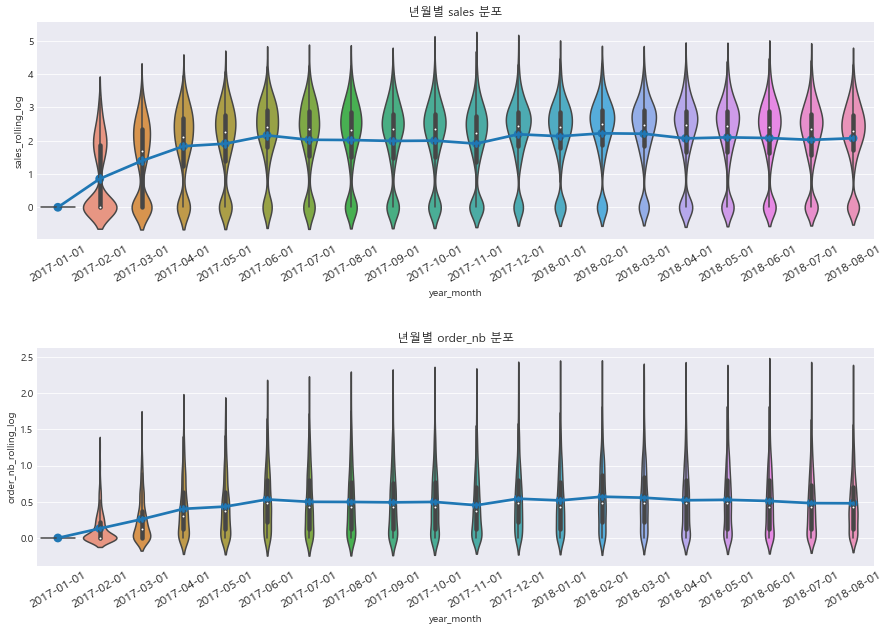

In [1231]:
fig,ax = plt.subplots(2,1,figsize = (15,10))
g = sns.violinplot(data = seller_rating.sort_values("year_month"), x = "year_month", y = "sales_rolling_log", ax = ax[0])
g = sns.pointplot(data = seller_rating.sort_values("year_month"), x = "year_month", y = "sales_rolling_log", ax = ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=30,fontsize = 12)
g.set_title("년월별 sales 분포")

g = sns.violinplot(data = seller_rating.sort_values("year_month"), x = "year_month", y = "order_nb_rolling_log", ax = ax[1])
g = sns.pointplot(data = seller_rating.sort_values("year_month"), x = "year_month", y = "order_nb_rolling_log", ax = ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=30,fontsize = 12)
g.set_title("년월별 order_nb 분포")

plt.subplots_adjust(hspace=0.5)
plt.show()

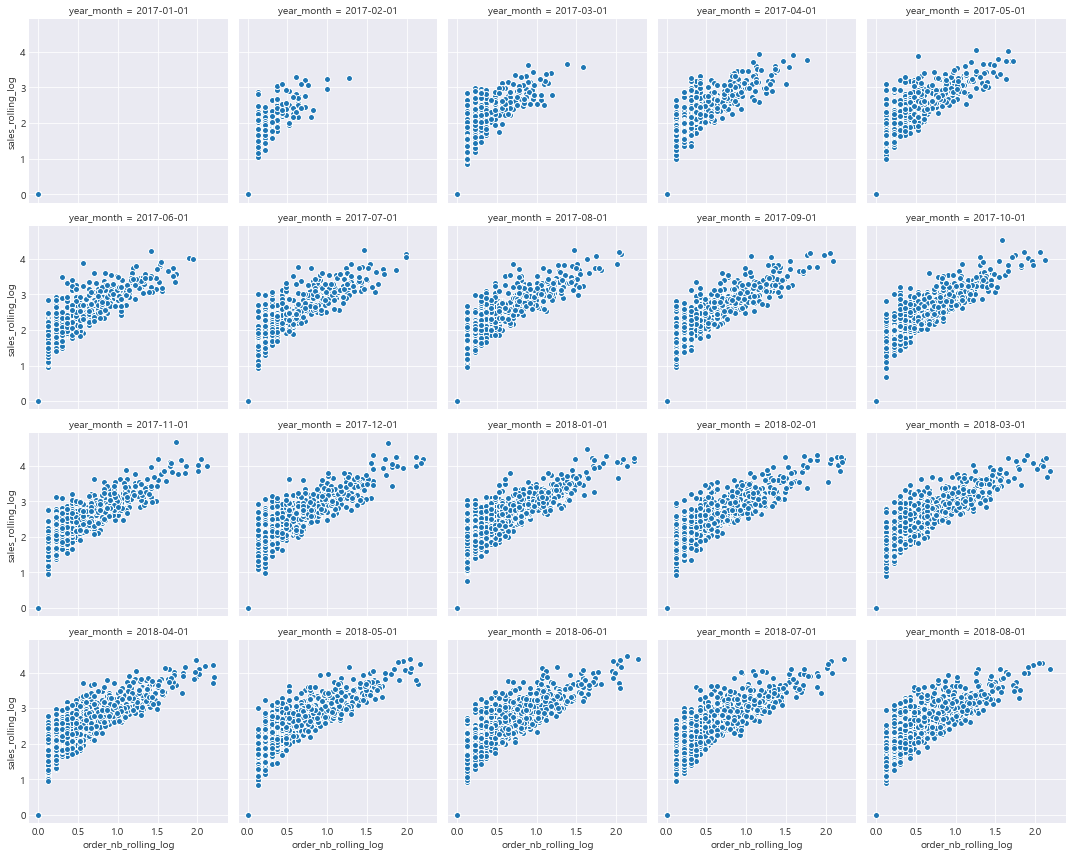

In [1232]:
# A FacetGrid
g2 = sns.FacetGrid(seller_rating.sort_values("year_month"), col="year_month",col_wrap=5)
g2.map(plt.scatter, "order_nb_rolling_log", "sales_rolling_log", edgecolor="w")

**graph로 봤을 때, 매출액 및 판매건수는 전체적으로 우상향하는 것으로 보임  
일단 Kmeans, 가우시안, 계층적 클러스터링을 해보기**


### clustering

In [1235]:
from sklearn.cluster import KMeans,SpectralClustering,AgglomerativeClustering, DBSCAN, GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import AffinityPropagation, 
from sklearn.mixture import 
# AgglomerativeClustering = Hierarchical clustering

def clustering_with_n_cluster(df, n_cluster):
    KM = KMeans(n_clusters= n_cluster , random_state =0) 
    SP = SpectralClustering(n_clusters= n_cluster , random_state =0)  
    AG = AgglomerativeClustering(n_clusters= n_cluster)
    
    GM = GaussianMixture(n_components=n_cluster, random_state = 0)
    BGM = BayesianGaussianMixture(n_components=n_cluster, random_state = 0)
    DC = DBSCAN()
    
    KM.fit(df)
    SP.fit(df)
    AG.fit(df)
    DC.fit(df)
    return pd.DataFrame({"KM" : KM.labels_.tolist(), "SP" : SP.labels_.tolist(), "AG" : AG.labels_.tolist(),
                          "GM" : GM.fit_predict(df).tolist(), "BGM" : BGM.fit_predict(df).tolist(),"DC" : DC.labels_.tolist()})

In [1236]:
labels_3 = clustering_with_n_cluster(seller_rating[["sales_rolling_log","order_nb_rolling_log"]],3)

In [1237]:
seller_rating = pd.concat([seller_rating,labels_3],axis=1)

AP = AffinityPropagation()
AP.fit(seller_rating[["sales_rolling_log","order_nb_rolling_log"]])

In [1238]:
seller_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15480 entries, 0 to 15479
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   seller_id             15480 non-null  object 
 1   year_month            15480 non-null  object 
 2   sales                 15480 non-null  float64
 3   order_nb              15480 non-null  float64
 4   sales_rolling         15480 non-null  float64
 5   order_nb_rolling      15480 non-null  float64
 6   sales_rolling_log     15480 non-null  float64
 7   order_nb_rolling_log  15480 non-null  float64
 8   KM                    15480 non-null  int64  
 9   SP                    15480 non-null  int64  
 10  AG                    15480 non-null  int64  
 11  GM                    15480 non-null  int64  
 12  BGM                   15480 non-null  int64  
 13  DC                    15480 non-null  int64  
dtypes: float64(6), int64(6), object(2)
memory usage: 1.7+ MB


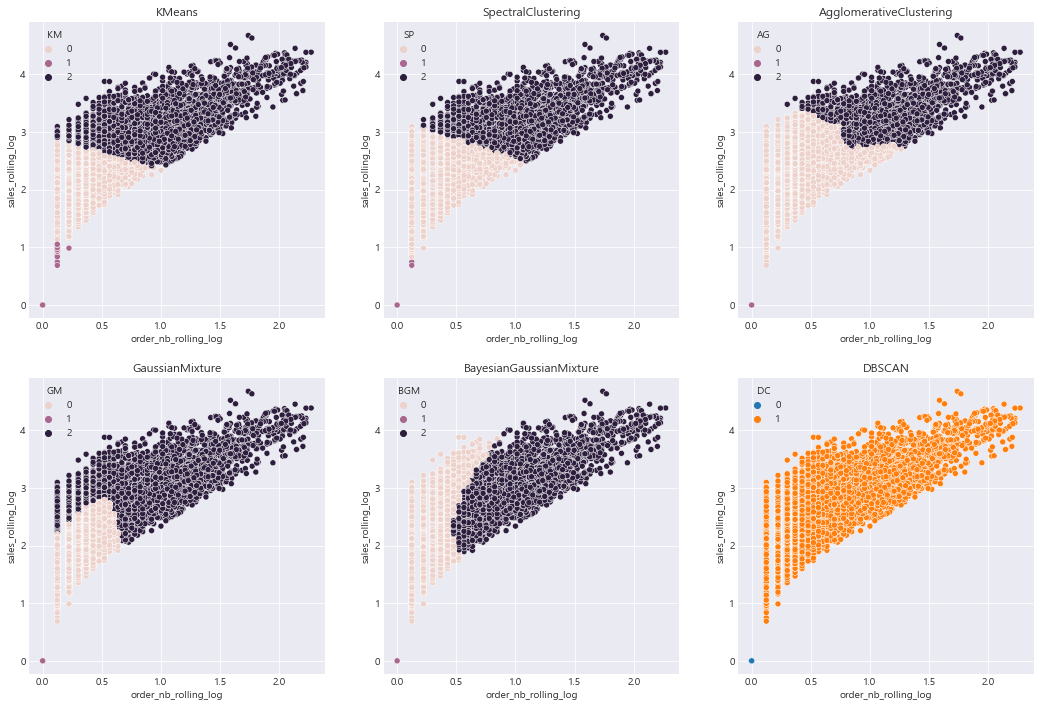

In [1242]:
fig,ax = plt.subplots(2,3,figsize = (18,12))

g=sns.scatterplot(data = seller_rating, x = "order_nb_rolling_log", y = "sales_rolling_log",hue = "KM", ax = ax[0,0])
g.set_title("KMeans")
g=sns.scatterplot(data = seller_rating, x = "order_nb_rolling_log", y = "sales_rolling_log",hue = "SP", ax = ax[0,1])
g.set_title("SpectralClustering")
g=sns.scatterplot(data = seller_rating, x = "order_nb_rolling_log", y = "sales_rolling_log",hue = "AG", ax = ax[0,2])
g.set_title("AgglomerativeClustering")
g=sns.scatterplot(data = seller_rating, x = "order_nb_rolling_log", y = "sales_rolling_log",hue = "GM", ax = ax[1,0])
g.set_title("GaussianMixture")
g=sns.scatterplot(data = seller_rating, x = "order_nb_rolling_log", y = "sales_rolling_log",hue = "BGM", ax = ax[1,1])
g.set_title("BayesianGaussianMixture")
g=sns.scatterplot(data = seller_rating, x = "order_nb_rolling_log", y = "sales_rolling_log",hue = "DC", ax = ax[1,2])
g.set_title("DBSCAN")
plt.show()

**매출액 및 매출건수가 우상향하지만 특정 군집을 해석하기가 어렵다고 생각함**  
**클러스터링 대신, grid를 기준으로 나눠보는게 어떤지 고민**  
1. Sales_rolling_log : 0 이상 1 미만 // order_nb_rolling_log : 0.0 이상 0.5미만
1. Sales_rolling_log : 1 이상 2 미만 // order_nb_rolling_log : 0.5 이상 1.0미만
1. Sales_rolling_log : 2 이상 3 미만 // order_nb_rolling_log : 1.0 이상 1.5미만
1. Sales_rolling_log : 3 이상 4 미만 // order_nb_rolling_log : 1.5 이상 2.0미만
1. Sales_rolling_log : 4 이상// order_nb_rolling_log : 2.0 이상

In [1279]:
def rating_cond(i):
    cond = (seller_rating.sales_rolling_log >=i)&(seller_rating.order_nb_rolling_log >=i/2)
    return cond

In [1280]:
seller_rating["rating"] = 0
for i in range(0,5):
    seller_rating.loc[rating_cond(i),"rating"] = i

In [1287]:
seller_rating.rating.value_counts().sort_index()/seller_rating.shape[0]*100

0    58.333333
1    28.320413
2    10.891473
3     2.151163
4     0.303618
Name: rating, dtype: float64

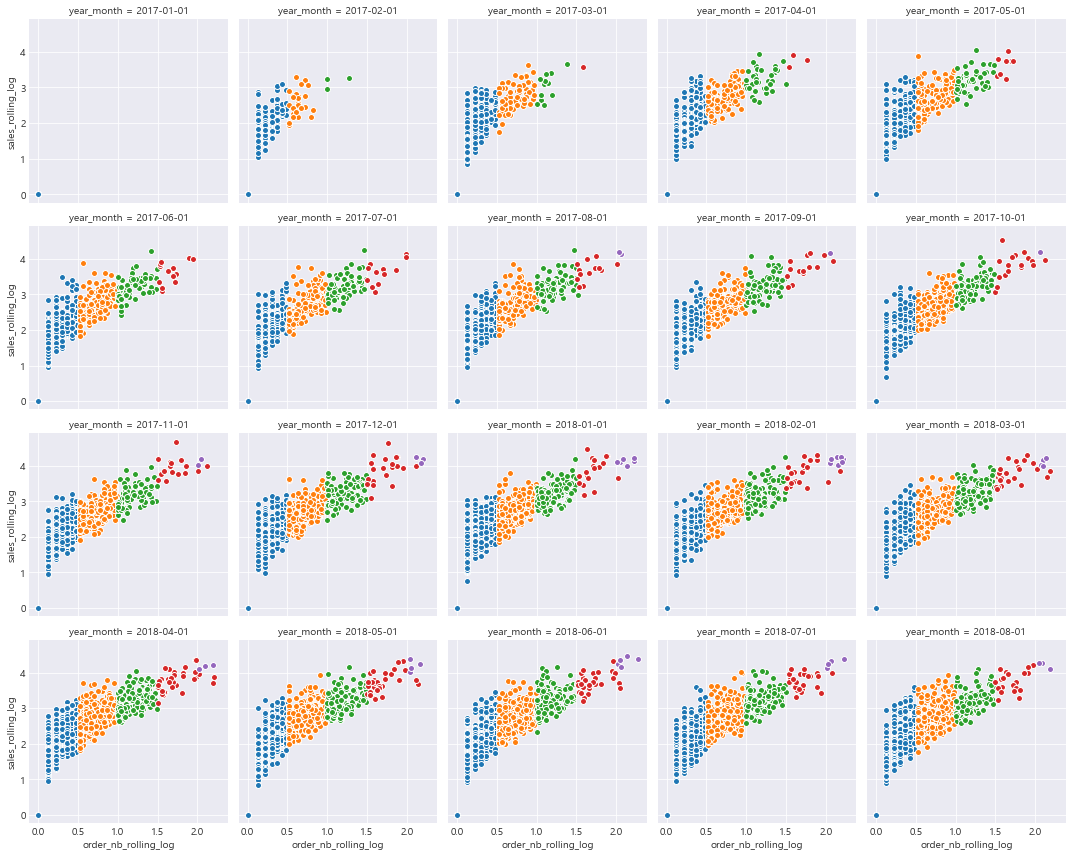

In [1288]:
g2 = sns.FacetGrid(seller_rating.sort_values("year_month"), col="year_month",col_wrap=5,hue = "rating")
g2.map(plt.scatter, "order_nb_rolling_log", "sales_rolling_log", edgecolor="w")

In [1294]:
seller_rating_temp = seller_rating[["seller_id","year_month","rating"]].copy()
df_model_temp

,year_month,seller_id,product_category_name_english,sales,order_nb,review_score,delivery_delay,delivery_periods,delivery_preparation,error_rate_based_on_CD,error_rate_based_on_estimated,dist,1,2,3,4,5,low_review_score_rate,product_category_upper,seles_by_OrderNumber,start_YearMonth,end_YearMonth
0,2016-12-01,004c9cd9d87a3c30c522c48c4fc07416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01,2018-05-01
1,2017-01-01,004c9cd9d87a3c30c522c48c4fc07416,bed_bath_table,702.87,5.0,4.200000,-19.000000,16.400000,0.400000,20.0,80.0,492.305675,0.0,1.0,0.0,1.0,3.0,20.0,home_living,140.574000,2017-01-01,2018-05-01
2,2017-02-01,004c9cd9d87a3c30c522c48c4fc07416,bed_bath_table,2308.83,13.0,4.230769,-18.461538,9.923077,1.307692,0.0,100.0,477.891775,0.0,0.0,4.0,2.0,7.0,31.0,home_living,177.602308,2017-01-01,2018-05-01
3,2017-03-01,004c9cd9d87a3c30c522c48c4fc07416,bed_bath_table,939.98,7.0,5.000000,-14.000000,6.428571,0.714286,0.0,100.0,417.785344,0.0,0.0,0.0,0.0,7.0,0.0,home_living,134.282857,2017-01-01,2018-05-01
4,2017-04-01,004c9cd9d87a3c30c522c48c4fc07416,bed_bath_table,1402.15,9.0,3.888889,-11.888889,13.888889,1.555556,0.0,100.0,610.714008,2.0,0.0,0.0,2.0,5.0,22.0,home_living,155.794444,2017-01-01,2018-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32780,2018-09-01,fdf736c18c589ed030e058312203e1b2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-01,2018-08-01
32781,2018-07-01,ff1e15b778c700abdd4d239b81ac466d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-01,2018-08-01
32782,2018-08-01,ff1e15b778c700abdd4d239b81ac466d,musical_instruments,71.81,1.0,5.000000,-2.000000,4.000000,3.000000,0.0,100.0,12.156774,0.0,0.0,0.0,0.0,1.0,0.0,culture,71.810000,2018-08-01,2018-08-01
32783,2018-08-01,ff1e15b778c700abdd4d239b81ac466d,sports_leisure,457.35,6.0,4.500000,-9.000000,7.500000,1.666667,0.0,100.0,660.748772,0.0,0.0,0.0,3.0,3.0,0.0,sports,76.225000,2018-08-01,2018-08-01


## 미정

In [415]:
df_model.groupby("year_month").review_score.mean()

year_month
2017-01-01    4.165215
2017-02-01    4.179965
2017-03-01    4.194818
2017-04-01    4.063038
2017-05-01    4.240684
2017-06-01    4.213125
2017-07-01    4.213371
2017-08-01    4.338983
2017-09-01    4.229182
2017-10-01    4.181071
2017-11-01    4.011565
2017-12-01    4.052320
2018-01-01    4.080774
2018-02-01    3.884258
2018-03-01    3.817487
2018-04-01    4.188050
2018-05-01    4.289189
2018-06-01    4.286319
2018-07-01    4.356238
2018-08-01    4.330749
Name: review_score, dtype: float64

In [416]:
for i in range(30):
    print(f"df_model의 order_nb >={i+1}개 이상인 row 수 : {df_model[df_model.order_nb >=(i+1)].shape[0]}")


df_model의 order_nb >=1개 이상인 row 수 : 23136
df_model의 order_nb >=2개 이상인 row 수 : 12388
df_model의 order_nb >=3개 이상인 row 수 : 8244
df_model의 order_nb >=4개 이상인 row 수 : 5999
df_model의 order_nb >=5개 이상인 row 수 : 4626
df_model의 order_nb >=6개 이상인 row 수 : 3739
df_model의 order_nb >=7개 이상인 row 수 : 3083
df_model의 order_nb >=8개 이상인 row 수 : 2575
df_model의 order_nb >=9개 이상인 row 수 : 2213
df_model의 order_nb >=10개 이상인 row 수 : 1958
df_model의 order_nb >=11개 이상인 row 수 : 1721
df_model의 order_nb >=12개 이상인 row 수 : 1549
df_model의 order_nb >=13개 이상인 row 수 : 1377
df_model의 order_nb >=14개 이상인 row 수 : 1235
df_model의 order_nb >=15개 이상인 row 수 : 1132
df_model의 order_nb >=16개 이상인 row 수 : 1027
df_model의 order_nb >=17개 이상인 row 수 : 939
df_model의 order_nb >=18개 이상인 row 수 : 876
df_model의 order_nb >=19개 이상인 row 수 : 810
df_model의 order_nb >=20개 이상인 row 수 : 750
df_model의 order_nb >=21개 이상인 row 수 : 705
df_model의 order_nb >=22개 이상인 row 수 : 659
df_model의 order_nb >=23개 이상인 row 수 : 623
df_model의 order_nb >=24개 이상인 row 수 : 584
df_mode

<AxesSubplot:xlabel='review_score', ylabel='Density'>

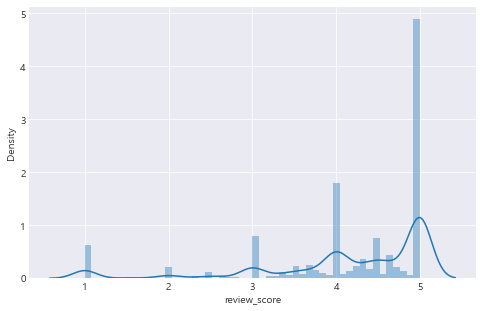

In [581]:
plt.figure(figsize = (8,5))
sns.distplot(df_model["review_score"])
# sns.distplot(np.log1p(df_model[df_model.order_nb >=(10)].review_score))



In [559]:
selected_columns = ['review_score','year_month', 'seller_id', 'product_category_upper', 'product_category_name_english',
                    'seles_by_OrderNumber','sales','order_nb','dist',
                    'delivery_delay', 'delivery_periods','delivery_preparation', 'error_rate_based_on_CD',
                    'error_rate_based_on_estimated','low_review_score_rate']
df_model = df_model[selected_columns]
df_model.to_excel("df_model.xlsx",index = False)

# 올리스트  
https://olist.com/planos/  &  https://olist.com/olist-store/  
https://get.olist.help/pt-BR/  
https://olist.com/faq/  
https://get.olist.help/pt-BR/articles/4856992-entenda-as-regras-de-comissionamento-e-frete-do-olist?_ga=2.59369453.1929511018.1614513656-1149340093.1613391697&_gac=1.93819375.1614091708.Cj0KCQiA7NKBBhDBARIsAHbXCB52_N1uIqfvjUSgGFhOgCrMvjl6iK7mDC-beGNnp_TZeSNo6BPe4CIaAncwEALw_wcB
- 올리스트는 마켓 플레이스 자체는 아니고, 하나의 백화점 형태이다. 올리스트 플랫폼에서도 제품을 판매하지만, 아마존, 아메라카나스, 줌 등 브라질의 다양한 마켓플레이스에서 상품을 판매 및 광고 등의 활동을 할 수 있도록 제공
- 올리스트 마켓 플레이스 판매자 등록비용 : 초기 계약 시 1회만 지불 
    - 제품당 커미션 부과 : 19~21%
    - 100달러 미만 : 고객이 배송비 100%부담, 판매자는 품목당 R$5dml 수수료 부담, 100달러 이상 : 정해진 테이블에 따라 판매자 및 올리스트가 나눠서 배송비 부담
    - 올리스트 스토어에서 수수료는 따로 부과하지 않고, 판매된 제품의 가치에 따른 수수료만 부담

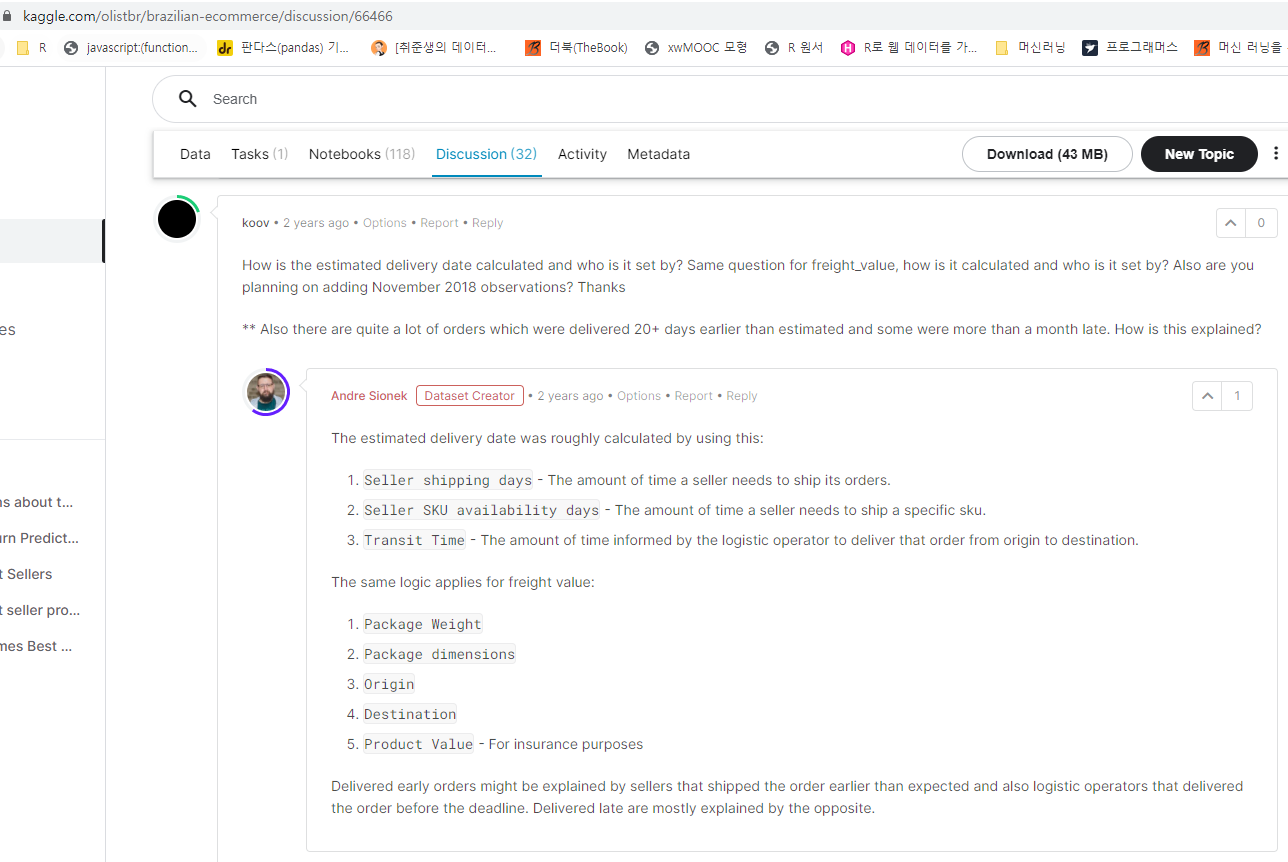

# EDA

## 판매자 기준

### 매출 총액

Text(0.5, 1.0, '판매자별 매출 총액 분포 log scale')

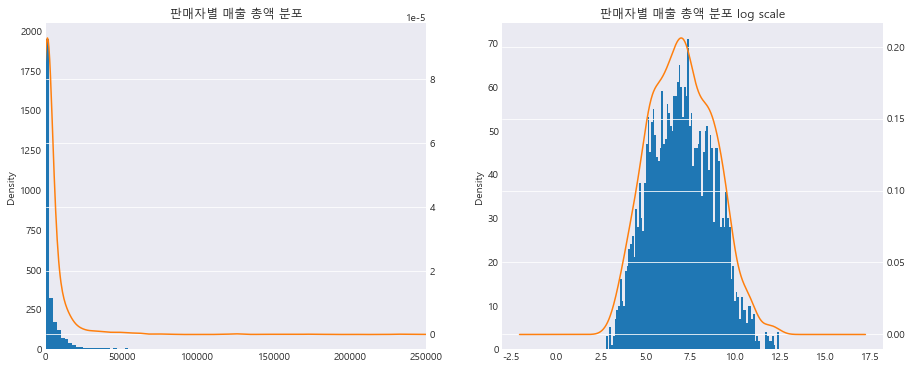

In [33]:
seller_sales_sum_mean = df_graph.groupby("seller_id").sales.agg(["sum"])
fig,ax = plt.subplots(1,2,figsize = (15,6))
seller_sales_sum_mean["sum"].plot.hist(bins = 100,ax=ax[0])
g = seller_sales_sum_mean["sum"].plot.kde(secondary_y = True,ax = ax[0])
g.set_title("판매자별 매출 총액 분포")
g.set_xlim(0,250000)

seller_sales_sum_mean["sum"].apply(np.log1p).plot.hist(bins = 100,ax=ax[1])
g1 = seller_sales_sum_mean["sum"].apply(np.log1p).plot.kde(secondary_y = True,ax = ax[1])
g1.set_title("판매자별 매출 총액 분포 log scale")

### 년분기별 매출 총액 cat

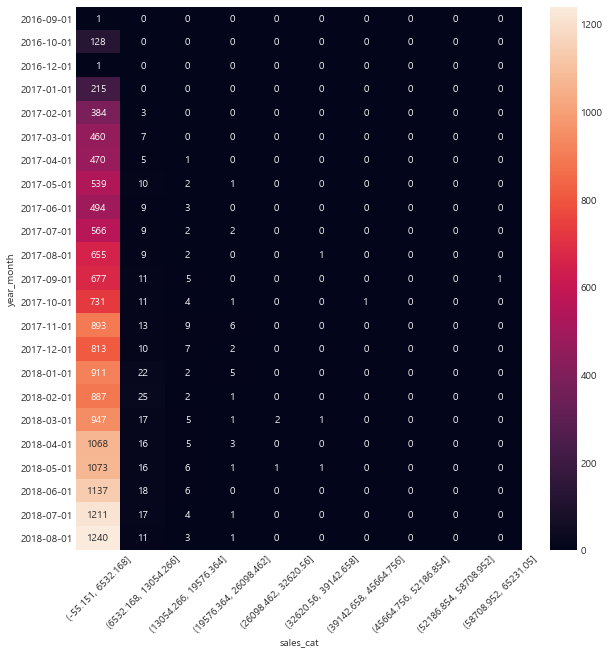

In [34]:
seller_sales_year_month = df_graph.groupby(["seller_id","year_month"]).sales.sum().reset_index()
seller_sales_year_month["sales_cat"] = pd.cut(x = seller_sales_year_month.sales,bins = 10)

temp = seller_sales_year_month.groupby(["year_month","sales_cat"]).seller_id.count().unstack()

fig,ax = plt.subplots(1,1,figsize = (10,10))
sns.heatmap(temp,annot = True, fmt = ".0f", ax = ax)
plt.xticks(rotation = 45)
plt.show()
# g.set_xticklabels(temp.columns, rotation = 45)

###  년분기별 매출총액 및 매출건수

In [35]:
df_graph.groupby(["seller_id","year_month"]).sales.sum().reset_index()

,seller_id,year_month,payment_value_cal
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09-01,916.02
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-01,1832.04
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02-01,1295.40
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03-01,2124.00
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04-01,2087.55
...,...,...,...
15836,fffd5413c0700ac820c7069d66d98c89,2018-06-01,365.44
15837,fffd5413c0700ac820c7069d66d98c89,2018-07-01,389.94
15838,fffd5413c0700ac820c7069d66d98c89,2018-08-01,624.33
15839,ffff564a4f9085cd26170f4732393726,2016-10-01,146.97


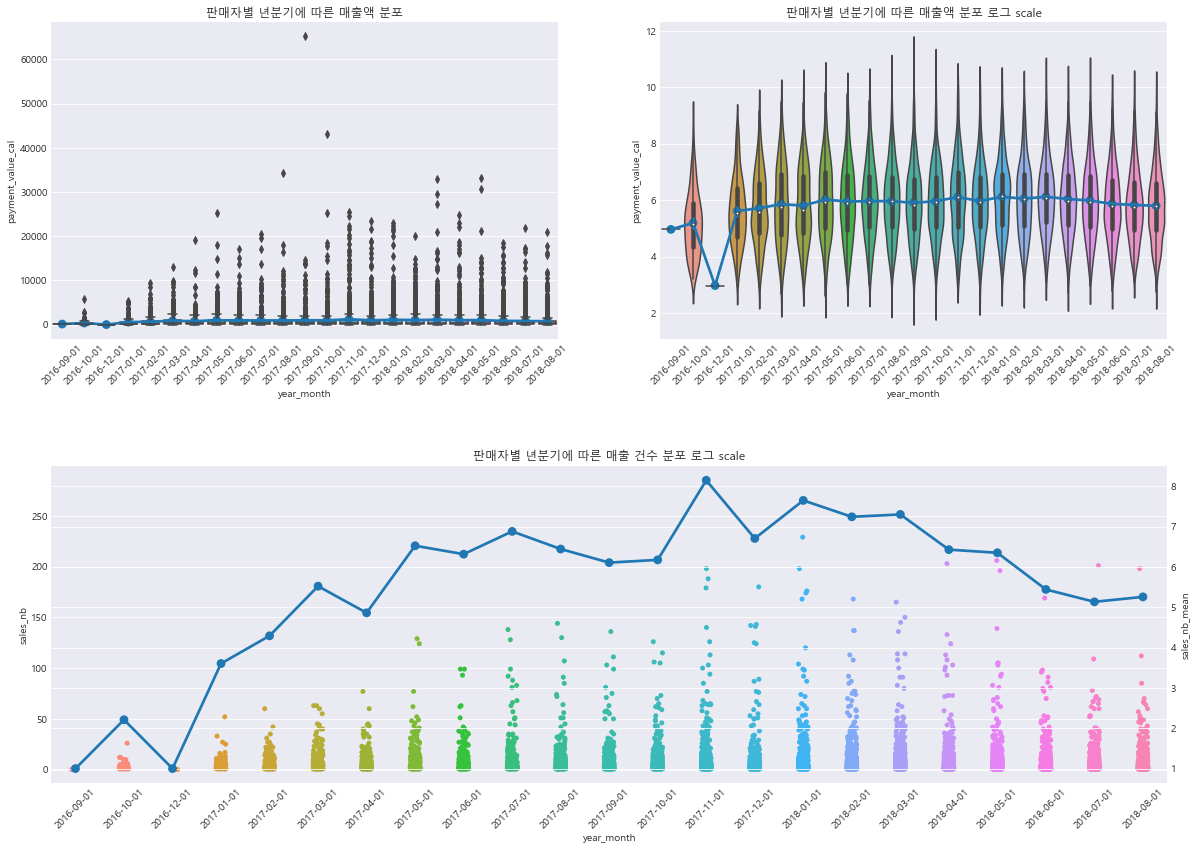

In [38]:
seller_sales = df_graph.groupby(["year_month","seller_id"]).sales.sum().reset_index()
seller_sales_log = seller_sales.copy()
seller_sales_log["sales"]=seller_sales_log["sales"].apply(np.log)

seller_sales_nb = df_graph.groupby(["year_month","seller_id"]).sales.count().reset_index().rename(columns = {"sales" : "sales_nb"})
seller_sales_nb_mean = seller_sales_nb.groupby("year_month").sales_nb.mean().reset_index().rename(columns = {"sales_nb":"sales_nb_mean"})
plt.figure(figsize = (20,14))
#sales 
plt.subplot(221)
sns.boxplot(data = seller_sales, x = "year_month", y = "sales")
sns.pointplot(data = seller_sales, x = "year_month", y = "sales")
plt.xticks(rotation = 45)
plt.title("판매자별 년분기에 따른 매출액 분포")

#sales log scale
plt.subplot(222)
sns.violinplot(data = seller_sales_log, x = "year_month", y = "sales")
sns.pointplot(data = seller_sales_log, x = "year_month", y = "sales")
plt.xticks(rotation = 45)
plt.title("판매자별 년분기에 따른 매출액 분포 로그 scale")

plt.subplot(212)
ax = sns.stripplot(data = seller_sales_nb, x = "year_month", y = "sales_nb")
ax_twinx = ax.twinx()
sns.pointplot(data = seller_sales_nb_mean, x = seller_sales_nb_mean.year_month.astype(str), y = "sales_nb_mean",ax=ax_twinx)
labels = ax.axes.get_xticklabels()
ax.axes.set_xticklabels(labels, rotation=45)
plt.title("판매자별 년분기에 따른 매출 건수 분포 로그 scale")

plt.subplots_adjust(hspace = 0.4)
plt.show()

### 판매자별 판매상품 개수

<AxesSubplot:ylabel='product_category_name_english'>

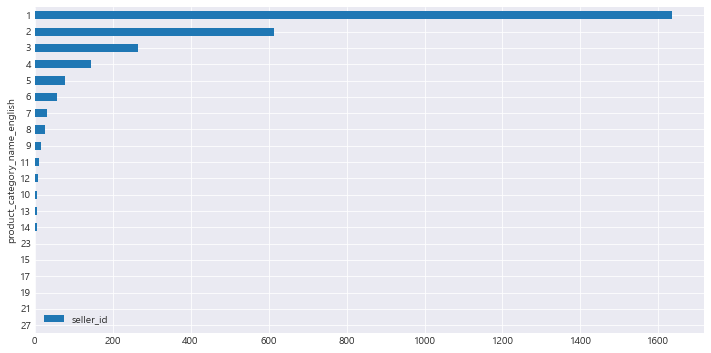

In [39]:
seller_cat_nb = df_graph[["seller_id","product_category_name_english"]].drop_duplicates(ignore_index=True)
seller_cat_nb = seller_cat_nb.groupby("seller_id").count().reset_index().groupby("product_category_name_english").count()

seller_cat_nb.sort_values("seller_id").plot.barh(figsize = (12,6))

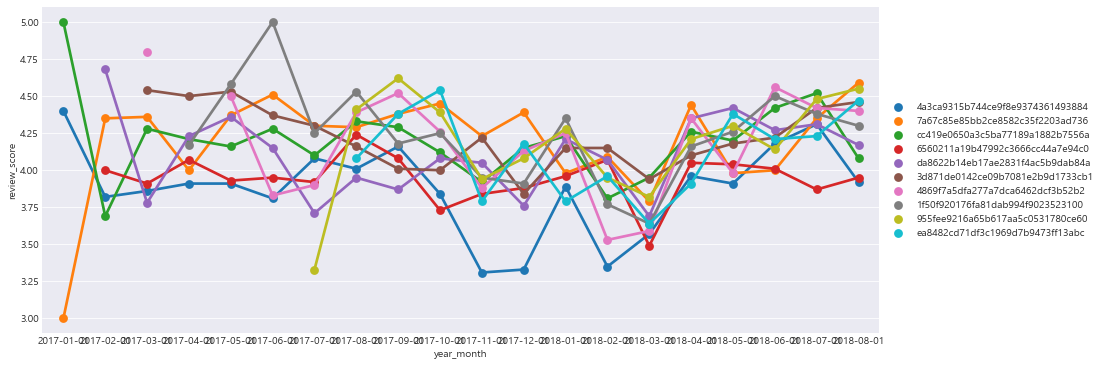

In [41]:
#상품 판매 건수가 많은 상위 10명의 판매자
seller_review_score = df_graph.groupby(["seller_id"]).review_score.agg(["mean","count"]).reset_index()
seller_top10_list = seller_review_score.sort_values("count", ascending = False).head(10).seller_id.tolist()

seller_top10_review_mean = df_graph[df_graph.seller_id.isin(seller_top10_list)].groupby(["year_month","seller_id"]).review_score.mean().reset_index().round(2)
plt.subplots(figsize = (15,6))
# seller_top10_review_mean
sns.pointplot(data = seller_top10_review_mean, x="year_month",y="review_score",hue = "seller_id")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**판매자에 따라 특정 기간에 고객이 없는 경우도 있음  
**


df_graph.order_purchase_timestamp.map(lambda x : dt.datetime(x.year,x.month,1)).dt.date